<a href="https://colab.research.google.com/github/naveencalex/HILDA-Project/blob/main/Predicting_Seismic_Events_in_Coal_Mines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Introduction**
The prediction of seismic events in coal mining operations is critical for ensuring the safety of miners, as these events pose substantial risks. In Poland, coal mining companies are legally mandated to adopt stringent safety protocols; however, current monitoring systems, which rely heavily on expert knowledge, sometimes fail to anticipate hazardous seismic activities, leading to potentially catastrophic outcomes. The AAIA'16 Data Mining Challenge, hosted as part of the FedCSIS conference, was initiated to address this issue by inviting participants to develop predictive models capable of identifying periods of heightened seismic activity in underground coal mines.
This study aims to develop a machine learning model to predict whether seismic energy levels will surpass a threshold of 5× 10^4Joules within the forthcoming eight-hour window, based on sensor data gathered over the previous 24 hours. Such a predictive capability has significant implications for proactive safety management in the mining sector, allowing for timely interventions to prevent accidents.
Furthermore, this research investigates the model’s adaptability across various mining sites, focusing on sites with historical seismic data (known sites) and those lacking such data (unknown sites). By analysing model performance across these contexts, we seek to establish a robust framework for deploying predictive models in settings with limited or no historical data. This report details the methodology employed, the key findings from model evaluations, and an analysis of feature importances and misclassification trends, which collectively inform strategies to enhance predictive accuracy and safety protocols in coal mining environments.


Data Loading

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

# Step 1: Load the Initial Training and Test Data
train_data = pd.read_csv("/content/drive/MyDrive/data/trainingData/trainingData.csv", header=None)
test_data = pd.read_csv("/content/drive/MyDrive/data/testData/testData.csv", header=None)

# Step 2: Load Column Names from Text File
with open("/content/drive/MyDrive/data/column_names.txt") as file:
    column_names = file.read().splitlines()

# Assign column names to both training and test datasets
train_data.columns = column_names
test_data.columns = column_names

# Step 3: Load Training Target and Test Target
train_target = pd.read_csv("/content/drive/MyDrive/data/trainingData/trainingLabels.csv", header=None)
with open("/content/drive/MyDrive/data/testData/test_labels.txt") as file:
    test_target = file.read().splitlines()

# Rename the column to "target" for both training and test targets
train_target.columns = ["target"]
test_target = pd.DataFrame({"target": test_target})

# Convert both training and test target variables to categories
train_target['target'] = pd.Categorical(train_target['target'], categories=["normal", "warning"])
test_target['target'] = pd.Categorical(test_target['target'], categories=["normal", "warning"])

# Step 4: Combine Training Data and Target
train_data_combined = pd.concat([train_data, train_target], axis=1)

# Similarly, combine the test data and test target
test_data_combined = pd.concat([test_data, test_target], axis=1)




# Optional: Check Model Residuals using DHARMa (not available in Python, but you can check residuals manually)


In [ ]:
# Step 4: Load 4 Additional Training Datasets and Their Targets
additional_train_data_1 = pd.read_csv("/content/drive/MyDrive/data/additional_data_1/additional_training_data_1.csv", header=None)
additional_train_data_2 = pd.read_csv("/content/drive/MyDrive/data/additional_data_2/additional_training_data_2.csv", header=None)
additional_train_data_3 = pd.read_csv("/content/drive/MyDrive/data/additional_data_3/additional_training_data_3.csv", header=None)
additional_train_data_4 = pd.read_csv("/content/drive/MyDrive/data/additional_data_4/additional_training_data_4.csv", header=None)

additional_train_target_1 = pd.read_csv("/content/drive/MyDrive/data/additional_data_1/additional_training_labels_1.csv", header=None)
additional_train_target_2 = pd.read_csv("/content/drive/MyDrive/data/additional_data_2/additional_training_labels_2.csv", header=None)
additional_train_target_3 = pd.read_csv("/content/drive/MyDrive/data/additional_data_3/additional_training_labels_3.csv", header=None)
additional_train_target_4 = pd.read_csv("/content/drive/MyDrive/data/additional_data_4/additional_training_labels_4.csv", header=None)

# Assign column names to the additional training datasets
additional_train_data_1.columns = column_names
additional_train_data_2.columns = column_names
additional_train_data_3.columns = column_names
additional_train_data_4.columns = column_names

# Rename target column in additional target data
additional_train_target_1.columns = ["target"]
additional_train_target_2.columns = ["target"]
additional_train_target_3.columns = ["target"]
additional_train_target_4.columns = ["target"]

# Convert target columns to categorical
additional_train_target_1['target'] = pd.Categorical(additional_train_target_1['target'], categories=["normal", "warning"])
additional_train_target_2['target'] = pd.Categorical(additional_train_target_2['target'], categories=["normal", "warning"])
additional_train_target_3['target'] = pd.Categorical(additional_train_target_3['target'], categories=["normal", "warning"])
additional_train_target_4['target'] = pd.Categorical(additional_train_target_4['target'], categories=["normal", "warning"])

# Step 5: Combine Additional Training Data and Targets
combined_train_data_1 = pd.concat([additional_train_data_1, additional_train_target_1], axis=1)
combined_train_data_2 = pd.concat([additional_train_data_2, additional_train_target_2], axis=1)
combined_train_data_3 = pd.concat([additional_train_data_3, additional_train_target_3], axis=1)
combined_train_data_4 = pd.concat([additional_train_data_4, additional_train_target_4], axis=1)

# Step 6: Combine all Training Data
train_data_combined = pd.concat([train_data_combined, combined_train_data_1, combined_train_data_2, combined_train_data_3, combined_train_data_4])


Metasite data Loading

In [ ]:
# Step 1: Load the metadata (assuming it is in a CSV format)
metadata = pd.read_csv('/content/working_site_metadata.csv')

metadata_subset = metadata[['main_working_id', 'main_working_height', 'mining_hazard_assessment']]

# Step 2: Merge metadata with training and test data based on 'main_working_id'
train_data_combined = pd.merge(train_data_combined, metadata_subset, on='main_working_id', how='left')
test_data_combined = pd.merge(test_data_combined, metadata_subset, on='main_working_id', how='left')

# Step 3: Check if the merge was successful
print(train_data_combined.head())
print(test_data_combined.head())


   main_working_id  total_bumps_energy  total_tremors_energy  \
0              146                 0.0                   0.0   
1              146                 0.0                   0.0   
2              146                 0.0                   0.0   
3              146                 0.0                   0.0   
4              146                 0.0                   0.0   

   total_destressing_blasts_energy  total_seismic_energy  \
0                              0.0                   0.0   
1                              0.0                   0.0   
2                              0.0                   0.0   
3                              0.0                   0.0   
4                              0.0                   0.0   

   latest_progress_estimation_l  latest_progress_estimation_r  \
0                           2.5                           2.5   
1                           2.5                           2.5   
2                           2.5                           2

In [ ]:
test_data_combined.head()

,main_working_id,total_bumps_energy,total_tremors_energy,total_destressing_blasts_energy,total_seismic_energy,latest_progress_estimation_l,latest_progress_estimation_r,latest_seismic_assessment,latest_seismoacoustic_assessment,latest_comprehensive_assessment,...,avg_difference_in_genergy.18,avg_difference_in_genergy.19,avg_difference_in_genergy.20,avg_difference_in_genergy.21,avg_difference_in_genergy.22,avg_difference_in_genergy.23,avg_difference_in_genergy.24,target,main_working_height,mining_hazard_assessment
0,765,0.0,0.0,0.0,0.000000,1.4,1.3,a,a,a,...,83.214417,-98.571274,46.873077,-95.313774,38.643616,50.930660,-61.138641,normal,1.4,a
1,575,0.0,0.0,0.0,2392.367974,2.1,1.4,a,b,a,...,289.737530,-40.700153,-64.514227,607.566132,534.216431,618.835541,326.560760,normal,3.0,b
2,777,1300.0,1300.0,0.0,1300.000000,3.0,4.1,a,b,a,...,-56.161699,13.459660,-87.875263,-59.104805,-34.735641,-66.600695,-85.155060,normal,3.4,b
3,149,0.0,0.0,0.0,76.924991,1.4,0.0,a,b,a,...,53.282186,44.907127,-31.292269,23.948773,4.597633,95.458321,28.076334,normal,2.2,b
4,725,3700.0,3700.0,0.0,3700.000000,1.0,1.0,c,b,b,...,-59.002108,111.214486,37.510170,-88.313122,95.191448,-63.202456,13.548837,warning,2.2,b


In [ ]:
train_data_combined.head()

,main_working_id,total_bumps_energy,total_tremors_energy,total_destressing_blasts_energy,total_seismic_energy,latest_progress_estimation_l,latest_progress_estimation_r,latest_seismic_assessment,latest_seismoacoustic_assessment,latest_comprehensive_assessment,...,avg_difference_in_genergy.18,avg_difference_in_genergy.19,avg_difference_in_genergy.20,avg_difference_in_genergy.21,avg_difference_in_genergy.22,avg_difference_in_genergy.23,avg_difference_in_genergy.24,target,main_working_height,mining_hazard_assessment
0,146,0.0,0.0,0.0,0.0,2.5,2.5,a,b,b,...,-17.824229,136.192734,75.746264,68.382465,112.918190,40.727715,128.499195,normal,2.0,a
1,146,0.0,0.0,0.0,0.0,2.5,2.5,a,b,b,...,136.192734,75.746264,68.382465,112.918190,40.727715,128.499195,18.919338,normal,2.0,a
2,146,0.0,0.0,0.0,0.0,2.5,2.5,a,b,b,...,75.746264,68.382465,112.918190,40.727715,128.499195,18.919338,310.288597,normal,2.0,a
3,146,0.0,0.0,0.0,0.0,2.5,2.5,a,b,b,...,68.382465,112.918190,40.727715,128.499195,18.919338,310.288597,-45.435540,normal,2.0,a
4,146,0.0,0.0,0.0,0.0,2.5,2.5,a,b,b,...,112.918190,40.727715,128.499195,18.919338,310.288597,-45.435540,32.676167,normal,2.0,a


In [ ]:
train_data_combined.describe()

,main_working_id,total_bumps_energy,total_tremors_energy,total_destressing_blasts_energy,total_seismic_energy,latest_progress_estimation_l,latest_progress_estimation_r,latest_maximum_yield,latest_maximum_meter,count_e2.1,...,avg_difference_in_genergy.16,avg_difference_in_genergy.17,avg_difference_in_genergy.18,avg_difference_in_genergy.19,avg_difference_in_genergy.20,avg_difference_in_genergy.21,avg_difference_in_genergy.22,avg_difference_in_genergy.23,avg_difference_in_genergy.24,main_working_height
count,133151.000000,1.331510e+05,1.331510e+05,133151.000000,1.331510e+05,133151.000000,133151.000000,133151.000000,133151.000000,133151.000000,...,133151.000000,133151.000000,133151.000000,133151.000000,133151.000000,133151.000000,133151.000000,133151.000000,133151.000000,133151.000000
mean,468.790779,5.307731e+04,5.253439e+04,52.186391,5.391530e+04,2.346084,2.450568,3.461921,8.781759,0.048314,...,0.921356,0.928207,0.932619,0.939449,0.940582,0.947310,0.952561,0.961685,0.969515,2.703080
std,205.980231,1.307192e+06,1.307156e+06,767.685495,1.307195e+06,1.455668,1.374095,0.471197,2.418789,0.280740,...,543.019623,543.019995,543.020812,543.021064,543.020588,543.020189,543.020111,543.021409,543.021598,0.896881
min,146.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,2.500000,4.000000,0.000000,...,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,1.400000
25%,264.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,1.400000,1.400000,3.500000,7.000000,0.000000,...,-89.794075,-89.788151,-89.786499,-89.783634,-89.778940,-89.773512,-89.770632,-89.767076,-89.766571,1.600000
50%,437.000000,0.000000e+00,0.000000e+00,0.000000,7.865040e+01,2.100000,2.100000,3.500000,9.000000,0.000000,...,-44.619676,-44.616955,-44.612038,-44.603764,-44.601223,-44.588947,-44.584127,-44.576000,-44.566203,3.000000
75%,725.000000,1.306787e+03,9.300000e+02,0.000000,3.380989e+03,4.200000,4.200000,3.500000,11.000000,0.000000,...,20.779788,20.784591,20.787070,20.805415,20.805415,20.819476,20.824668,20.829683,20.841251,3.500000
max,793.000000,9.246746e+07,9.246746e+07,46820.000000,9.246746e+07,7.700000,8.400000,5.000000,12.000000,16.000000,...,159527.437500,159527.437500,159527.437500,159527.437500,159527.437500,159527.437500,159527.437500,159527.437500,159527.437500,4.400000


**Feature Engineering and Data Augmentation**
1.	**Mean Aggregation of Sensor Data**: The mean values over the last 24 hours were calculated for each sensor feature. This choice was made to smooth out hourly fluctuations, thus focusing on general trends that could correlate with seismic events.
2.	**Metadata Integration**: We integrated main_working_height and mining_hazard_assessment from the metadata to enhance the model's context. These features offer additional insight into site-specific conditions that may affect seismic risk.


In [ ]:
def aggregate_sensor_data_mean(df, column_prefix):
    # Select the columns for the given prefix and hours 17-24
    cols = [col for col in df.columns if col.startswith(column_prefix) and any(f'.{i}' in col for i in range(1, 25))]
    # Aggregate the data by computing the mean for the selected columns
    return df[cols].mean(axis=1)

# Step 6: Aggregate each type of sensor data for the last 8 hours in both training and test datasets (using mean)
# Aggregating previously used sensor types
train_data_combined['mean_count_e2'] = aggregate_sensor_data_mean(train_data_combined, 'count_e2')
train_data_combined['mean_count_e3'] = aggregate_sensor_data_mean(train_data_combined, 'count_e3')
train_data_combined['mean_count_e4'] = aggregate_sensor_data_mean(train_data_combined, 'count_e4')
train_data_combined['mean_count_e5'] = aggregate_sensor_data_mean(train_data_combined, 'count_e5')
train_data_combined['mean_count_e6plus'] = aggregate_sensor_data_mean(train_data_combined, 'count_e6plus')

train_data_combined['mean_sum_e2'] = aggregate_sensor_data_mean(train_data_combined, 'sum_e2')
train_data_combined['mean_sum_e3'] = aggregate_sensor_data_mean(train_data_combined, 'sum_e3')
train_data_combined['mean_sum_e4'] = aggregate_sensor_data_mean(train_data_combined, 'sum_e4')
train_data_combined['mean_sum_e5'] = aggregate_sensor_data_mean(train_data_combined, 'sum_e5')
train_data_combined['mean_sum_e6plus'] = aggregate_sensor_data_mean(train_data_combined, 'sum_e6plus')

train_data_combined['mean_avg_gactivity'] = aggregate_sensor_data_mean(train_data_combined, 'avg_gactivity')
train_data_combined['mean_avg_genergy'] = aggregate_sensor_data_mean(train_data_combined, 'avg_genergy')

# Aggregating the new columns for max_difference and avg_difference
train_data_combined['mean_max_difference_in_gactivity'] = aggregate_sensor_data_mean(train_data_combined, 'max_difference_in_gactivity')
train_data_combined['mean_max_difference_in_genergy'] = aggregate_sensor_data_mean(train_data_combined, 'max_difference_in_genergy')
train_data_combined['mean_avg_difference_in_gactivity'] = aggregate_sensor_data_mean(train_data_combined, 'avg_difference_in_gactivity')
train_data_combined['mean_avg_difference_in_genergy'] = aggregate_sensor_data_mean(train_data_combined, 'avg_difference_in_genergy')

# Repeat the same aggregation for the test dataset
test_data_combined['mean_count_e2'] = aggregate_sensor_data_mean(test_data_combined, 'count_e2')
test_data_combined['mean_count_e3'] = aggregate_sensor_data_mean(test_data_combined, 'count_e3')
test_data_combined['mean_count_e4'] = aggregate_sensor_data_mean(test_data_combined, 'count_e4')
test_data_combined['mean_count_e5'] = aggregate_sensor_data_mean(test_data_combined, 'count_e5')
test_data_combined['mean_count_e6plus'] = aggregate_sensor_data_mean(test_data_combined, 'count_e6plus')

test_data_combined['mean_sum_e2'] = aggregate_sensor_data_mean(test_data_combined, 'sum_e2')
test_data_combined['mean_sum_e3'] = aggregate_sensor_data_mean(test_data_combined, 'sum_e3')
test_data_combined['mean_sum_e4'] = aggregate_sensor_data_mean(test_data_combined, 'sum_e4')
test_data_combined['mean_sum_e5'] = aggregate_sensor_data_mean(test_data_combined, 'sum_e5')
test_data_combined['mean_sum_e6plus'] = aggregate_sensor_data_mean(test_data_combined, 'sum_e6plus')

test_data_combined['mean_avg_gactivity'] = aggregate_sensor_data_mean(test_data_combined, 'avg_gactivity')
test_data_combined['mean_avg_genergy'] = aggregate_sensor_data_mean(test_data_combined, 'avg_genergy')

# Aggregating the new columns for max_difference and avg_difference in test set
test_data_combined['mean_max_difference_in_gactivity'] = aggregate_sensor_data_mean(test_data_combined, 'max_difference_in_gactivity')
test_data_combined['mean_max_difference_in_genergy'] = aggregate_sensor_data_mean(test_data_combined, 'max_difference_in_genergy')
test_data_combined['mean_avg_difference_in_gactivity'] = aggregate_sensor_data_mean(test_data_combined, 'avg_difference_in_gactivity')
test_data_combined['mean_avg_difference_in_genergy'] = aggregate_sensor_data_mean(test_data_combined, 'avg_difference_in_genergy')

In [ ]:
# Step 7: Add Key Seismic Assessment Features
# Keep seismic assessments and combine with the aggregated sensor data
X_train = train_data_combined[['mean_count_e2', 'mean_count_e3', 'mean_count_e4', 'mean_count_e5', 'mean_count_e6plus',
                               'mean_sum_e2', 'mean_sum_e3', 'mean_sum_e4', 'mean_sum_e5', 'mean_sum_e6plus',
                               'mean_avg_gactivity', 'mean_avg_genergy', 'mean_max_difference_in_gactivity',
                               'mean_max_difference_in_genergy', 'mean_avg_difference_in_gactivity',
                               'mean_avg_difference_in_genergy',
                               'latest_seismic_assessment', 'latest_comprehensive_assessment','main_working_height','mining_hazard_assessment']]

X_test = test_data_combined[['mean_count_e2', 'mean_count_e3', 'mean_count_e4', 'mean_count_e5', 'mean_count_e6plus',
                             'mean_sum_e2', 'mean_sum_e3', 'mean_sum_e4', 'mean_sum_e5', 'mean_sum_e6plus',
                             'mean_avg_gactivity', 'mean_avg_genergy', 'mean_max_difference_in_gactivity',
                             'mean_max_difference_in_genergy', 'mean_avg_difference_in_gactivity',
                             'mean_avg_difference_in_genergy',
                             'latest_seismic_assessment', 'latest_comprehensive_assessment','main_working_height','mining_hazard_assessment']]


In [ ]:
# Convert categorical variables into dummy/one-hot encoding
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Prepare target variables
y_train = train_data_combined['target'].cat.codes
y_test = test_data_combined['target'].cat.codes


In [ ]:
y_train.value_counts()

,count
0,130188
1,2963


In [ ]:
X_train.columns

In [ ]:
X_test.columns

In [ ]:
# Align the order of columns in X_test to match X_train
X_test = X_test[X_train.columns]


In [ ]:
X_train.head()

In [ ]:
X_test.head()

In [ ]:
# Convert True/False to 0/1 in both X_train and X_test
X_train = X_train.replace({True: 1, False: 0})
X_test = X_test.replace({True: 1, False: 0})

# Ensure all values are now numeric
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Check for any missing values and handle them if necessary
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

<ipython-input-10-e829faa89b7f>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train = X_train.replace({True: 1, False: 0})
<ipython-input-10-e829faa89b7f>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_test = X_test.replace({True: 1, False: 0})


In [ ]:
X_train.info()

In [ ]:
import pandas
import numpy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

**Standardization**
In the raw data, extreme outliers were observed, particularly in features: mean_sum_e6plus ,mean_avg_gactivity ,  mean_max_difference_in_gactivity .These outliers could skew the model, leading to biased predictions.

**Effect of Standardization**

After standardizing, the distribution became more normalized, although some outliers remained. Attempts to apply log transformations were found to reduce model accuracy, so standardized data was retained without further transformations. This approach provided a more balanced dataset while retaining essential variations in the data.


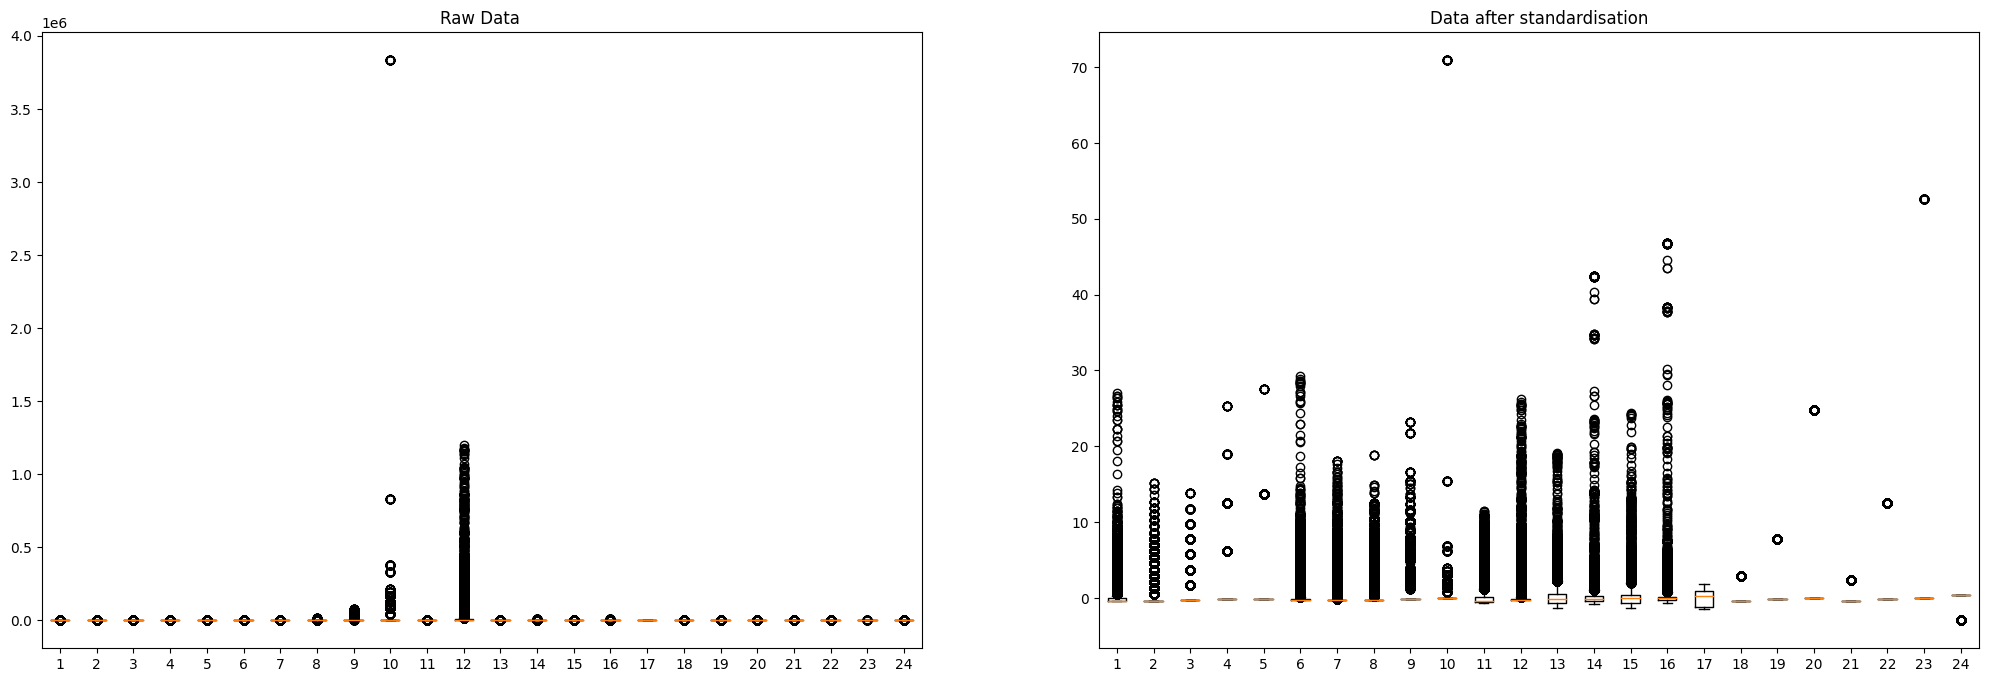

In [ ]:
# plot box plot for the data
fig = plt.figure(figsize=[25, 8])
ax = fig.add_subplot(1, 2, 1)
ax.boxplot(X_train)
ax.set_title('Raw Data ')


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)





# box plot after standardisation
ax = fig.add_subplot(1, 2, 2)
ax.boxplot(X_train_scaled)
ax.set_title('Data after standardisation');

**Class Imbalance and Resampling Techniques**

Due to an imbalance in the target classes, where seismic events are underrepresented,
•	130,188 instances of class 0 (non-seismic events or normal state)
•	2,963 instances of class 1 (seismic events or warning state)
•	This imbalance means that class 1, representing seismic warnings, is heavily underrepresented compared to class 0. Without addressing this imbalance, the model would likely become biased towards predicting the majority class (class 0), potentially overlooking critical seismic events (class 1).
  we implemented the following techniques:

•	**SMOTE (Synthetic Minority Over-sampling Technique):** SMOTE was applied to generate synthetic samples of seismic events, ensuring a more balanced dataset for training.


In [ ]:
# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)



Text(0.5, 1.0, 'Raw Data after Smote')

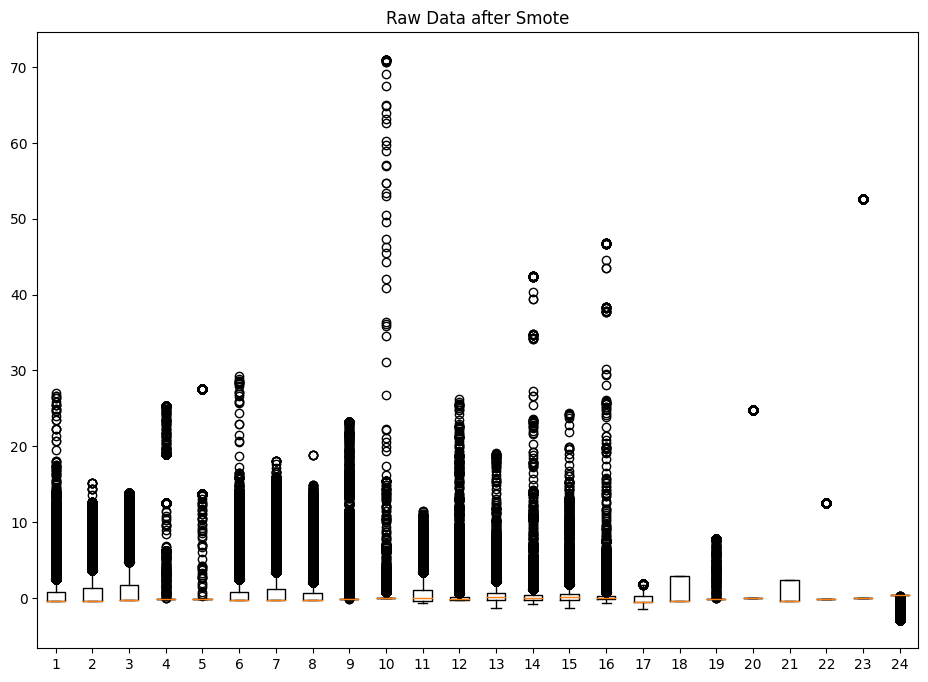

In [ ]:
# plot box plot for the data
fig = plt.figure(figsize=[25, 8])
ax = fig.add_subplot(1, 2, 1)
ax.boxplot(X_train_resampled)
ax.set_title('Raw Data after Smote')

In [ ]:
X_test.head()

,mean_count_e2,mean_count_e3,mean_count_e4,mean_count_e5,mean_count_e6plus,mean_sum_e2,mean_sum_e3,mean_sum_e4,mean_sum_e5,mean_sum_e6plus,...,mean_avg_difference_in_gactivity,mean_avg_difference_in_genergy,main_working_height,latest_seismic_assessment_b,latest_seismic_assessment_c,latest_seismic_assessment_d,latest_comprehensive_assessment_b,latest_comprehensive_assessment_c,latest_comprehensive_assessment_d,mining_hazard_assessment_b
0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,-27.333333,-0.959227,1.4,0,0,0,0,0,0,0
1,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,221.829190,228.790289,3.0,0,0,0,0,0,0,1
2,0.083333,0.0,0.0,0.0,0.0,54.166667,0.0,0.0,0.0,0.0,...,-18.831156,-36.480953,3.4,0,0,0,0,0,0,1
3,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,-0.183137,32.501883,2.2,0,0,0,0,0,0,1
4,0.208333,0.0,0.0,0.0,0.0,154.166667,0.0,0.0,0.0,0.0,...,-4.850419,47.107356,2.2,0,1,0,1,0,0,1


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score



# Train the logistic regression model with resampled data
logistic_model = LogisticRegression(max_iter=500)
logistic_model.fit(X_train_resampled, y_train_resampled)

# Step 10: Predictions and Model Evaluation
y_pred = logistic_model.predict(X_test_scaled)
y_pred_prob = logistic_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_prob)

# Print the evaluation results
print("Confusion Matrix:\n", conf_matrix)
print("\nAccuracy:", accuracy)
print("\nClassification Report:\n", classification_rep)
print("\nAUC Score:", auc_score)


Confusion Matrix:
 [[3296  368]
 [  45  151]]

Accuracy: 0.8930051813471502

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.90      0.94      3664
           1       0.29      0.77      0.42       196

    accuracy                           0.89      3860
   macro avg       0.64      0.83      0.68      3860
weighted avg       0.95      0.89      0.91      3860


AUC Score: 0.9193936035112735


In [ ]:
y_test.value_counts()

,count
0,3664
1,196


In [ ]:

X_train_resampled.shape

(260376, 24)

**Variance Inflation Factor (VIF)**: We applied VIF with a threshold of 5 to detect and remove highly correlated variables, thus addressing potential multicollinearity issues and improving model stability.
The Variance Inflation Factor (VIF) scores shown in the below figure highlight the level of multicollinearity among the features in the dataset before and after the removal of highly collinear features.





**Modelling Approach**
Our project focused on predicting seismic events in coal mines, particularly addressing challenges like imbalanced data and varied site conditions. To achieve this, we carefully selected and optimized machine learning models capable of handling these complexities.

•	**Model Selection**: We tried several models to see which would perform best:

o	**Ridge Regression:** A regularized linear model, chosen for its effectiveness with high-dimensional data and ability to reduce overfitting.

o	**MLP (Multi-Layer Perceptron) Classifier**: A type of neural network that captures complex relationships within the data, well-suited for this task.

o	**Random Forest:** An ensemble of decision trees, selected for its robustness against noise and its natural ability to handle imbalanced datasets.

o	**XGBoost:** A gradient-boosted tree model known for its accuracy and effectiveness on structured data.

o	**K-Nearest Neighbors (KNN):** Although not ideal for imbalanced data, KNN was included for baseline comparison.

•	**Hyperparameter Tuning**: Each model’s parameters were fine-tuned using Grid Search Cross-Validation (CV), where we tried various combinations to identify the best settings for each. For example, we adjusted the regularization in Ridge Regression, hidden layer sizes in MLP, and the number of trees in Random Forest and XGBoost. This ensured that each model was optimized for this specific dataset.


VIF before removing high collinearity features:
                               feature        VIF
0                       mean_count_e2  26.727352
1                       mean_count_e3  13.535184
2                       mean_count_e4   8.667180
3                       mean_count_e5   7.440278
4                   mean_count_e6plus   1.602141
5                         mean_sum_e2  28.319126
6                         mean_sum_e3  13.807347
7                         mean_sum_e4   8.270640
8                         mean_sum_e5   7.441030
9                     mean_sum_e6plus   1.565029
10                 mean_avg_gactivity   5.556355
11                   mean_avg_genergy   3.143372
12   mean_max_difference_in_gactivity  22.890709
13     mean_max_difference_in_genergy  27.815404
14   mean_avg_difference_in_gactivity  18.920696
15     mean_avg_difference_in_genergy  24.321843
16                main_working_height   1.270044
17        latest_seismic_assessment_b   2.875243
18        latest_sei

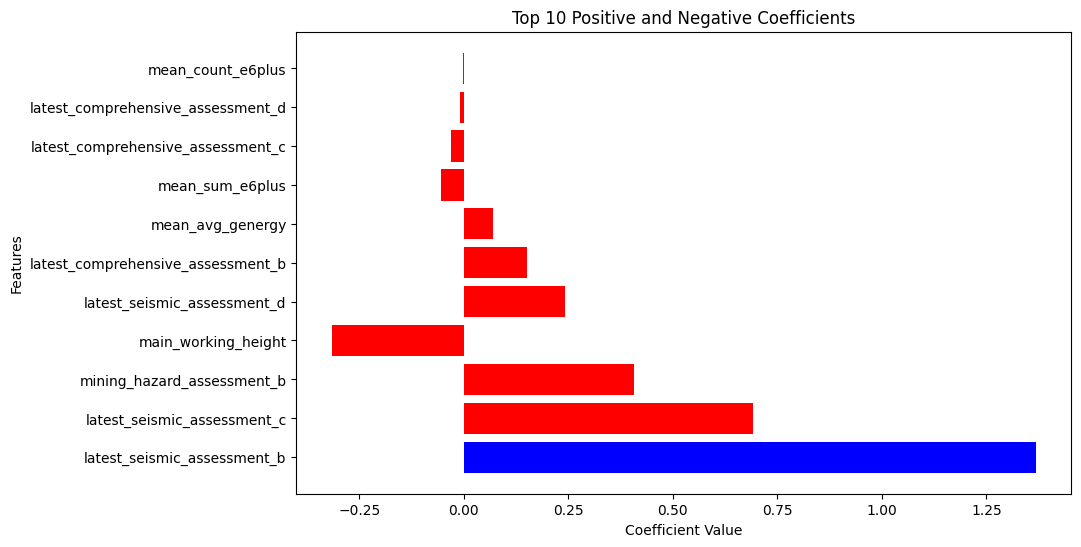

In [ ]:
  import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# Convert scaled numpy arrays to DataFrames for easier feature handling
X_train_scaled_df = pd.DataFrame(X_train_resampled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Step 2: Check for multicollinearity using VIF and remove high VIF features
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Calculate VIF for training data
vif = calculate_vif(X_train_scaled_df)
print("VIF before removing high collinearity features:\n", vif)

# Step 3: Remove features with VIF > 5 (manual selection based on VIF)
high_vif_columns = vif[vif["VIF"] > 5]["feature"]
X_train_scaled_df = X_train_scaled_df.drop(columns=high_vif_columns)
X_test_scaled_df = X_test_scaled_df.drop(columns=high_vif_columns)

# Recalculate VIF after dropping high VIF features
vif_after = calculate_vif(X_train_scaled_df)
print("VIF after removing high collinearity features:\n", vif_after)


# Check the distribution of target classes after SMOTE
print("Class distribution after SMOTE:", y_train_resampled.value_counts())

# Step 5: Perform logistic regression using regularization (L2 regularization)
logistic_reg_model = LogisticRegression(penalty='l2', solver='saga', max_iter=1000)  # Using saga solver for large dataset and regularization

# Fit the model on SMOTE-balanced training data
logistic_reg_model.fit(X_train_scaled_df, y_train_resampled)

# Make predictions on the test data
y_pred = logistic_reg_model.predict(X_test_scaled_df)
y_pred_prob = logistic_reg_model.predict_proba(X_test_scaled_df)[:, 1]

# Step 6: Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_prob)

# Print the evaluation results
print("Confusion Matrix:\n", conf_matrix)
print("\nAccuracy:", accuracy)
print("\nClassification Report:\n", classification_rep)
print("\nAUC Score:", auc_score)

# Optional: Check model coefficients
print("\nModel Coefficients:\n", pd.DataFrame(logistic_reg_model.coef_, columns=X_train_scaled_df.columns))

# Step 7: Visualize important coefficients (Optional)
# Plot top 10 positive and negative coefficients
coef_df = pd.DataFrame({
    "Feature": X_train_scaled_df.columns,
    "Coefficient": logistic_reg_model.coef_[0]
})

# Sort by absolute value of the coefficient
coef_df["abs_coef"] = np.abs(coef_df["Coefficient"])
coef_df = coef_df.sort_values(by="abs_coef", ascending=False)

# Plot top 10 positive and negative coefficients
plt.figure(figsize=(10, 6))
plt.barh(coef_df["Feature"][:10], coef_df["Coefficient"][:10], color="blue")
plt.barh(coef_df["Feature"][-10:], coef_df["Coefficient"][-10:], color="red")
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.title("Top 10 Positive and Negative Coefficients")
plt.show()


In [ ]:
X_train_scaled_df = X_train_scaled_df.drop(['mean_count_e6plus', 'mean_avg_genergy', 'mean_sum_e6plus'], axis=1)
X_test_scaled_df = X_test_scaled_df.drop(['mean_count_e6plus', 'mean_avg_genergy', 'mean_sum_e6plus'], axis=1)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Define the RandomForestClassifier with the specified hyperparameters
rf_model = RandomForestClassifier(
    random_state=42,           # Ensure reproducibility
    class_weight='balanced',   # Handle class imbalance by weighting the classes inversely proportional to their frequency
    max_depth=None,            # Allow the trees to expand until all leaves are pure or until they contain fewer than min_samples_split samples
    min_samples_leaf=1,        # Minimum number of samples required to be at a leaf node
    min_samples_split=2,       # Minimum number of samples required to split an internal node
    n_estimators=200           # Number of trees in the forest
)

# Fit the model to the training data
rf_model.fit(X_train_scaled_df, y_train_resampled)

# Make predictions on the test data
y_pred_rf = rf_model.predict(X_test_scaled_df)

# If you need probabilities for evaluation (e.g., for AUC)
y_pred_prob_rf = rf_model.predict_proba(X_test_scaled_df)[:, 1]

# Evaluate the model
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score

# Confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Accuracy score
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# Classification report
classification_rep_rf = classification_report(y_test, y_pred_rf)

# AUC score
auc_score_rf = roc_auc_score(y_test, y_pred_prob_rf)

# Print the evaluation results
print("Confusion Matrix (Random Forest):\n", conf_matrix_rf)
print("\nAccuracy (Random Forest):", accuracy_rf)
print("\nClassification Report (Random Forest):\n", classification_rep_rf)
print("\nAUC Score (Random Forest):", auc_score_rf)

**•	Hyperparameter Tuning:** Each model’s parameters were fine-tuned using Grid Search Cross-Validation (CV), where we tried various combinations to identify the best settings for each. For example, we adjusted the regularization in Ridge Regression, hidden layer sizes in MLP, and the number of trees in Random Forest and XGBoost. This ensured that each model was optimized for this specific dataset.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score
import numpy as np

# Step 1: Define models and their hyperparameter grids
models = {
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced',),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "Logistic Regression": LogisticRegression(penalty='l2', solver='saga', max_iter=1000, class_weight='balanced')
}

param_grids = {
    "Random Forest": {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2, 4]
    },
    "K-Nearest Neighbors": {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]  # For choosing between Manhattan (p=1) and Euclidean (p=2)
    },
    "XGBoost": {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 6, 10],
        'subsample': [0.8, 1.0]
    },
    "Logistic Regression": {
        'C': [0.01, 0.1, 1, 10]  # Regularization strength
    }
}

# Step 2: Define a scoring metric (we'll use AUC score for grid search)
scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)

# Step 3: Perform GridSearchCV for each model
best_estimators = {}
for model_name, model in models.items():
    print(f"\nPerforming Grid Search for {model_name}...\n")

    # Define GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[model_name],
        scoring=scorer,  # Use AUC as the scoring metric
        cv=5,  # 5-fold cross-validation
        n_jobs=-1,  # Use all available cores
        verbose=3
    )

    # Fit the model with grid search
    grid_search.fit(X_train_scaled_df, y_train_resampled)

    # Store the best estimator
    best_estimators[model_name] = grid_search.best_estimator_

    print(f"Best Parameters for {model_name}:\n", grid_search.best_params_)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Function to evaluate models
def evaluate_models_and_plot_roc(best_estimators, X_test, y_test):
    plt.figure(figsize=(10, 7))

    for model_name, model in best_estimators.items():
        # Make predictions
        y_pred_prob = model.predict_proba(X_test)[:, 1]

        # Calculate ROC AUC
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        auc_score = roc_auc_score(y_test, y_pred_prob)

        # Plot the ROC curve
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')

    # Plot a diagonal line for random guessing
    plt.plot([0, 1], [0, 1], 'k--')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for All Models')
    plt.legend(loc='lower right')
    plt.show()

# Call the function with the best models
evaluate_models_and_plot_roc(best_estimators, X_test_scaled_df, y_test)


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming best_estimators is a dictionary storing the best models for each model type
for model_name, best_model in best_estimators.items():
    print(f"Confusion Matrix for {model_name}")

    # Make predictions with the best model
    y_pred = best_model.predict(X_test_scaled_df)

    # Generate the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Visualize the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Class 0", "Class 1"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()


In [ ]:
import numpy as np
import statsmodels.api as sm

# Get the predicted probabilities for the test set from logistic regression model
logit_best_model = best_estimators['Logistic Regression']
y_pred_prob_logit = logit_best_model.predict_proba(X_test_scaled_df)[:, 1]

# Log-odds (logit) of the predicted probabilities
logit_values = np.log(y_pred_prob_logit / (1 - y_pred_prob_logit))

# Check linearity assumption by plotting logit against features
for i, feature in enumerate(X_train_scaled_df.columns):  # Make sure columns are accessible
    plt.figure(figsize=(6, 4))
    plt.scatter(X_test_scaled_df.iloc[:, i], logit_values, color="blue", alpha=0.5)
    plt.xlabel(f"{feature}")
    plt.ylabel("Log-odds")
    plt.title(f"Logit vs {feature}")
    plt.show()



In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Get the predicted values (logit_best_model is the logistic regression model)
y_pred = logit_best_model.predict(X_test_scaled_df)

# Calculate the residuals (actual - predicted)
residuals = y_test - y_pred

# QQ plot of residuals
sm.qqplot(residuals, line='s')
plt.title('QQ Plot of Residuals')
plt.show()

# Histogram of residuals
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


In [ ]:
from sklearn.neural_network import MLPClassifier

# Initialize MLP Classifier
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

# Fit the model
mlp_model.fit(X_train_scaled_df, y_train_resampled)

# Make predictions
y_pred_mlp = mlp_model.predict(X_test_scaled_df)
y_pred_prob_mlp = mlp_model.predict_proba(X_test_scaled_df)[:, 1]

# Evaluation
conf_matrix = confusion_matrix(y_test, y_pred_mlp)
accuracy = accuracy_score(y_test, y_pred_mlp)
classification_rep = classification_report(y_test, y_pred_mlp)
auc_score = roc_auc_score(y_test, y_pred_prob_mlp)

print("\nConfusion Matrix (MLP):\n", conf_matrix)
print("\nAccuracy (MLP):", accuracy)
print("\nClassification Report (MLP):\n", classification_rep)
print("\nAUC Score (MLP):", auc_score)



Confusion Matrix (MLP):
 [[3451  213]
 [  67  129]]

Accuracy (MLP): 0.927461139896373

Classification Report (MLP):
               precision    recall  f1-score   support

           0       0.98      0.94      0.96      3664
           1       0.38      0.66      0.48       196

    accuracy                           0.93      3860
   macro avg       0.68      0.80      0.72      3860
weighted avg       0.95      0.93      0.94      3860


AUC Score (MLP): 0.8890389671152303


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score, roc_curve
import matplotlib.pyplot as plt

# Step 1: Initialize the MLP Classifier
mlp_model = MLPClassifier(max_iter=1000, random_state=42)

# Step 2: Set up a parameter grid for hyperparameter tuning
param_grid = {
    'hidden_layer_sizes': [(100, 50), (150, 100)],  # Different network structures
    'activation': [ 'relu'],  # Activation functions
    'solver': ['adam', 'sgd'],  # Optimization solvers
    'alpha': [0.01],  # L2 penalty (regularization term)
    'learning_rate': ['adaptive'],  # Learning rate schedules
}

# Step 3: Grid Search for hyperparameter tuning
grid_search = GridSearchCV(mlp_model, param_grid, cv=5, scoring='roc_auc', verbose=3, n_jobs=-1)

# Step 4: Fit the model on the already scaled data
grid_search.fit(X_train_scaled_df, y_train_resampled)

# Step 5: Get the best parameters and model
best_mlp_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Step 6: Evaluate the Model
# Make predictions on the test data
y_pred_mlp = best_mlp_model.predict(X_test_scaled_df)
y_pred_prob_mlp = best_mlp_model.predict_proba(X_test_scaled_df)[:, 1]

# Confusion Matrix
conf_matrix_mlp = confusion_matrix(y_test, y_pred_mlp)

# Accuracy, AUC, and Classification Report
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
classification_rep_mlp = classification_report(y_test, y_pred_mlp)
auc_score_mlp = roc_auc_score(y_test, y_pred_prob_mlp)

# Print the evaluation results
print("Confusion Matrix:\n", conf_matrix_mlp)
print("\nAccuracy:", accuracy_mlp)
print("\nClassification Report:\n", classification_rep_mlp)
print("\nAUC Score:", auc_score_mlp)

# Step 7: Plot the ROC curve for MLP
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_mlp)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'MLP Classifier (AUC = {auc_score_mlp:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for MLP Classifier')
plt.legend(loc='lower right')
plt.show()


In [ ]:
X_train_scaled_df.head()

Taking the best parameters



Training MLP Classifier...

Confusion Matrix for MLP Classifier:
 [[3275  389]
 [  26  170]]

Training Random Forest...

Confusion Matrix for Random Forest:
 [[3235  429]
 [  19  177]]

Training K-Nearest Neighbors...

Confusion Matrix for K-Nearest Neighbors:
 [[3557  107]
 [ 158   38]]

Training XGBoost...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:50:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Confusion Matrix for XGBoost:
 [[3250  414]
 [  23  173]]

Training L2 Regularized Regression (Ridge)...

Confusion Matrix for L2 Regularized Regression (Ridge):
 [[3213  451]
 [  15  181]]


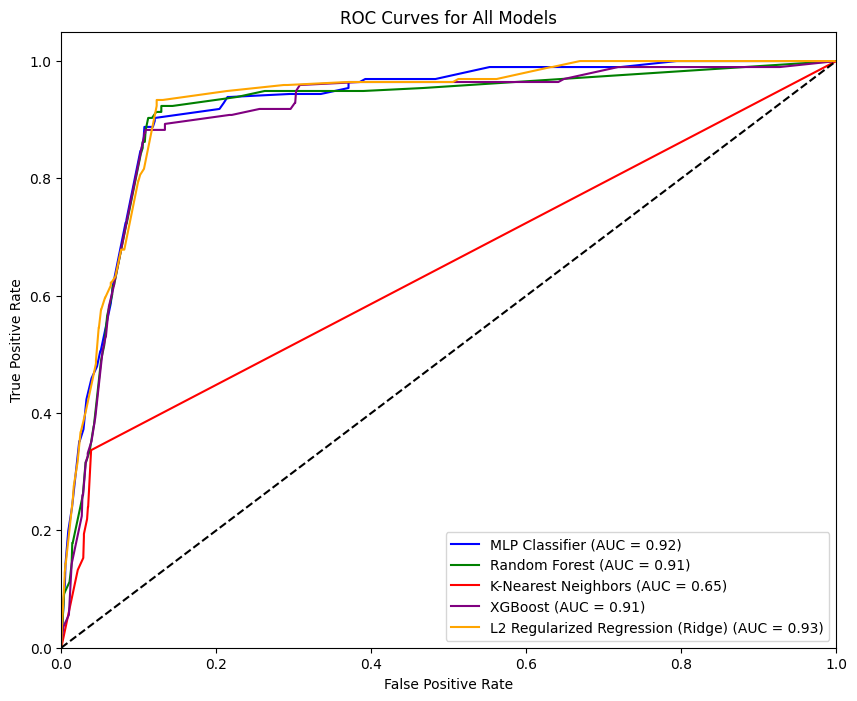

KeyError: "['precision', 'recall', 'f1-score'] not in index"

In [ ]:
# Putting the entire code flow together

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
import seaborn as sns

# Assuming SMOTE has already been applied to X_train_scaled_df and y_train_resampled.

# Define models with their best parameters
models = {
    "MLP Classifier": MLPClassifier(activation='relu', alpha=0.01, hidden_layer_sizes=(150, 100),
                                    learning_rate='adaptive', solver='sgd', random_state=42),
    "Random Forest": RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2,
                                            n_estimators=200, random_state=42, class_weight='balanced'),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=7, p=2, weights='distance'),
    "XGBoost": xgb.XGBClassifier(learning_rate=0.3, max_depth=10, n_estimators=200, subsample=0.8,
                                 use_label_encoder=False, eval_metric='logloss', random_state=42),
    "L2 Regularized Regression (Ridge)": LogisticRegression(C=0.01, penalty='l2', solver='saga', max_iter=1000,
                                              class_weight='balanced')
}

# Create an empty list to store classification reports
classification_reports = []

# Dictionary to store AUC scores
auc_scores = {}

# Initialize figure for ROC curves
plt.figure(figsize=(10, 8))

# Store colors for ROC plot
colors = ['blue', 'green', 'red', 'purple', 'orange']

# Loop through each model, fit, predict and visualize
for i, (model_name, model) in enumerate(models.items()):
    print(f"\nTraining {model_name}...")

    # Train the model
    model.fit(X_train_scaled_df, y_train_resampled)

    # Make predictions
    y_pred = model.predict(X_test_scaled_df)
    y_pred_prob = model.predict_proba(X_test_scaled_df)[:, 1]  # Get probabilities for ROC and AUC

    # Store classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    classification_reports.append(pd.DataFrame(report).transpose())  # Append each report to the list

    # Compute AUC score
    auc = roc_auc_score(y_test, y_pred_prob)
    auc_scores[model_name] = auc

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, color=colors[i], label=f'{model_name} (AUC = {auc:.2f})')

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix for {model_name}:\n", conf_matrix)

# ROC Plot Setup
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc='lower right')
plt.show()



In [ ]:
# Combine classification reports into one DataFrame
combined_reports = pd.concat(classification_reports, keys=models.keys(), axis=1)

# Print the index to check available labels
print("Classification Report Index:\n", combined_reports.index)


Classification Report Index:
 Index(['0', '1', 'accuracy', 'macro avg', 'weighted avg'], dtype='object')


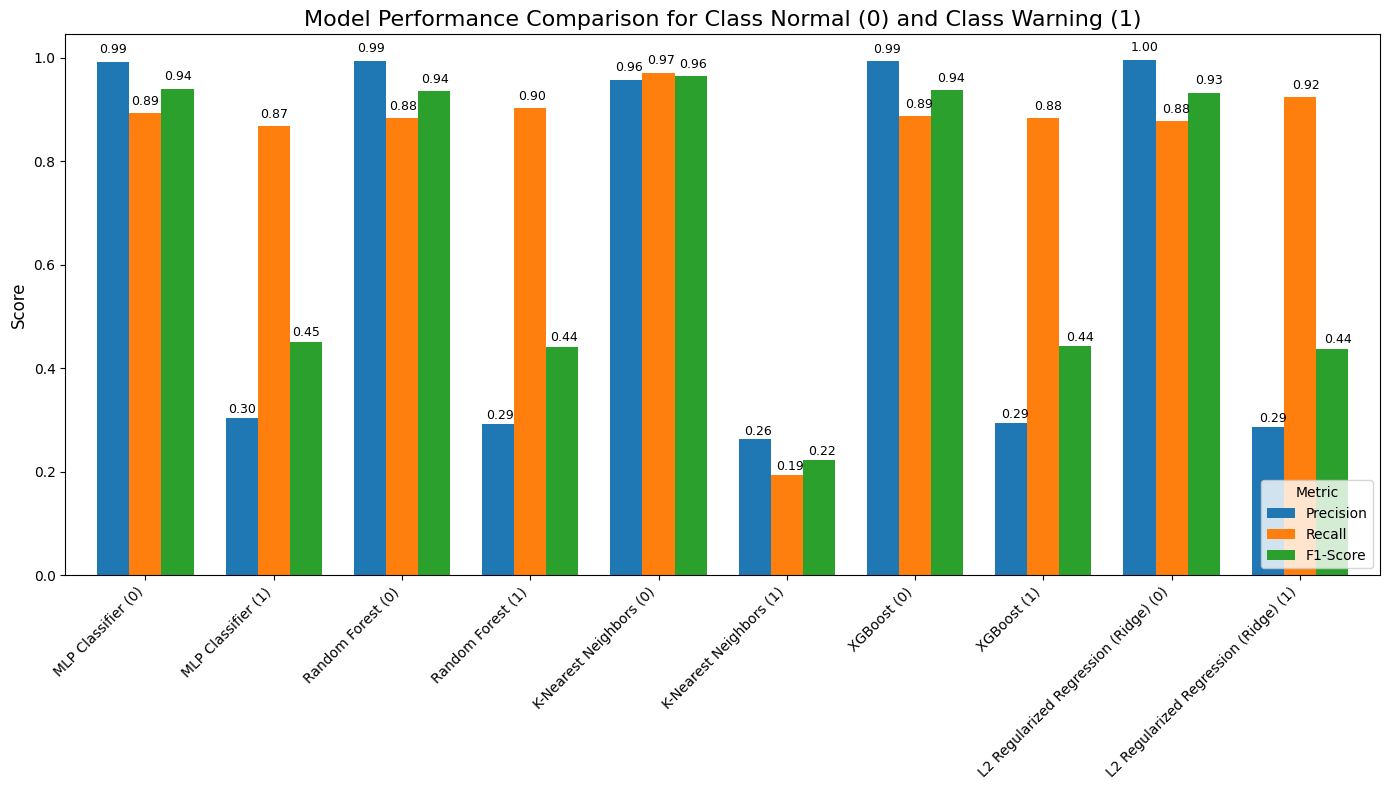

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create a dictionary to hold the data for each model and metric
data = {
    "MLP Classifier (0)": [0.992124, 0.893832, 0.940416],
    "MLP Classifier (1)": [0.304114, 0.867347, 0.450331],
    "Random Forest (0)": [0.994161, 0.882915, 0.935241],
    "Random Forest (1)": [0.292079, 0.903061, 0.441397],
    "K-Nearest Neighbors (0)": [0.957470, 0.970797, 0.964087],
    "K-Nearest Neighbors (1)": [0.262069, 0.193878, 0.222874],
    "XGBoost (0)": [0.992973, 0.887009, 0.937004],
    "XGBoost (1)": [0.294719, 0.882653, 0.441890],
    "L2 Regularized Regression (Ridge) (0)": [0.995353, 0.876910, 0.932385],
    "L2 Regularized Regression (Ridge) (1)": [0.286392, 0.923469, 0.437198]
}

# Create a DataFrame from the data
metrics_df = pd.DataFrame(data, index=['Precision', 'Recall', 'F1-Score'])

# Transpose the DataFrame for plotting
metrics_transposed = metrics_df.T

# Create a color list to distinguish models
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Plot the metrics as grouped bar charts
ax = metrics_transposed.plot(kind='bar', figsize=(14, 8), width=0.75, color=colors)
plt.title("Model Performance Comparison for Class Normal (0) and Class Warning (1)", fontsize=16)
plt.ylabel("Score", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='lower right', title="Metric", fontsize=10)

# Annotating the bars with their heights (values)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() * 1.005 + p.get_width() / 2., p.get_height() * 1.01),
                ha='center', va='center', fontsize=9, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()

# Show the plot
plt.show()


<Figure size 600x600 with 0 Axes>

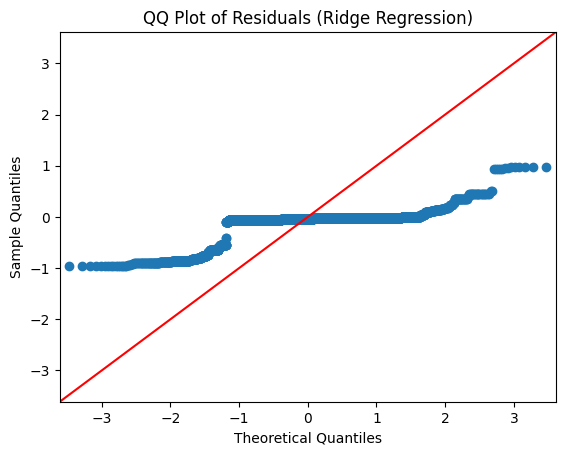

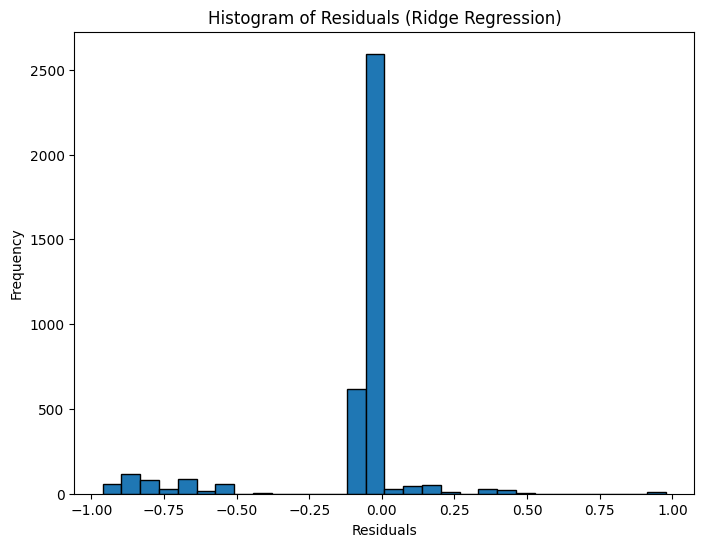

In [ ]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats

# Extract the Ridge Regression model from the models dictionary
ridge_model = models["L2 Regularized Regression (Ridge)"]

# Fit the Ridge Regression model on the training data (assuming you've already scaled and used SMOTE)
ridge_model.fit(X_train_scaled_df, y_train_resampled)

# Get predicted probabilities from the Ridge model
y_pred_prob_ridge = ridge_model.predict_proba(X_test_scaled_df)[:, 1]

# Calculate residuals: Actual labels (y_test) - predicted probabilities
residuals = y_test - y_pred_prob_ridge

# QQ Plot of Residuals
plt.figure(figsize=(6, 6))
sm.qqplot(residuals, line='45')
plt.title("QQ Plot of Residuals (Ridge Regression)")
plt.show()

# Histogram of Residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title("Histogram of Residuals (Ridge Regression)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


**Model Diagnostics and Assumptions**
To validate model assumptions and ensure robustness:
•	Ridge Regression: Despite a high AUC score, diagnostic plots (QQ plot and residual histogram) revealed deviations from normality assumptions. The residuals were skewed, indicating that the model might not fully capture the non-linear relationships in the data.


In [ ]:
MLP_MODEL = models["MLP Classifier"]


**Performance Across Known and Unknown Sites:** In our study, we differentiated mining sites into two categories: known and unknown. This categorization is based on the availability of historical data for each site in both the training and test datasets:

**•	Known Sites:** These are sites that have records in both the training and test datasets. The main_working_id identifiers for known sites include [765, 575, 777, 149, 725, 607, 793, 599, 583, 155, 479, 146, 541]. Having historical data allows the model to learn from past patterns and apply this knowledge when predicting seismic events at these sites.

**•	Unknown Sites:** These sites appear only in the test data, meaning no historical data was available for training the model. The main_working_id identifiers for unknown sites include [799, 490, 689, 470, 703, 508, 171, 641]. This "cold start" scenario presents a challenge, as the model has to generalize its predictions without prior information specific to these sites.
The distinction between known and unknown sites allows us to assess how well the MLP  model performs in both familiar and unfamiliar environments


In [ ]:
# Retrieve 'main_working_id' from train_data_combined and test_data_combined
main_working_id_train = train_data_combined['main_working_id']
main_working_id_test = test_data_combined['main_working_id']

# Step 1: Separate known and unknown sites based on 'main_working_id' in the test data
known_sites_indices = main_working_id_test[main_working_id_test.isin(main_working_id_train)].index
unknown_sites_indices = main_working_id_test[~main_working_id_test.isin(main_working_id_train)].index

# Step 2: Extract the rows for known and unknown sites
X_known = X_test_scaled_df.loc[known_sites_indices]
X_unknown = X_test_scaled_df.loc[unknown_sites_indices]

# Extract the corresponding y_test values for known and unknown sites
y_known = y_test.loc[known_sites_indices]
y_unknown = y_test.loc[unknown_sites_indices]

# Step 3: Evaluate the models for both known and unknown sites
def evaluate_model_performance(model, X, y_true, label):
    y_pred = model.predict(X)
    y_pred_prob = model.predict_proba(X)[:, 1]

    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_prob)
    conf_matrix = confusion_matrix(y_true, y_pred)
    class_report = classification_report(y_true, y_pred)

    print(f"Performance on {label} Sites:")
    print("Confusion Matrix:\n", conf_matrix)
    print(f"Accuracy: {acc}")
    print(f"AUC: {auc}")
    print("Classification Report:\n", class_report)
    print("-" * 50)



print("MLP Classifier")
evaluate_model_performance(MLP_MODEL, X_known, y_known, "Known")
evaluate_model_performance(MLP_MODEL, X_unknown, y_unknown, "Unknown")



MLP Classifier
Performance on Known Sites:
Confusion Matrix:
 [[2173  347]
 [  18  155]]
Accuracy: 0.8644634236910509
AUC: 0.9108347096063859
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92      2520
           1       0.31      0.90      0.46       173

    accuracy                           0.86      2693
   macro avg       0.65      0.88      0.69      2693
weighted avg       0.95      0.86      0.89      2693

--------------------------------------------------
Performance on Unknown Sites:
Confusion Matrix:
 [[1102   42]
 [   8   15]]
Accuracy: 0.9571550985432733
AUC: 0.9560086652477957
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98      1144
           1       0.26      0.65      0.38        23

    accuracy                           0.96      1167
   macro avg       0.63      0.81      0.68      1167
weighted avg       0.98      0.

MLP Classifier
Performance on Known Sites:
Confusion Matrix:
 [[2173  347]
 [  18  155]]
Accuracy: 0.8644634236910509
AUC: 0.9108347096063859
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92      2520
           1       0.31      0.90      0.46       173

    accuracy                           0.86      2693
   macro avg       0.65      0.88      0.69      2693
weighted avg       0.95      0.86      0.89      2693

--------------------------------------------------
Performance on Unknown Sites:
Confusion Matrix:
 [[1102   42]
 [   8   15]]
Accuracy: 0.9571550985432733
AUC: 0.9560086652477957
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98      1144
           1       0.26      0.65      0.38        23

    accuracy                           0.96      1167
   macro avg       0.63      0.81      0.68      1167
weighted avg       0.98      0.

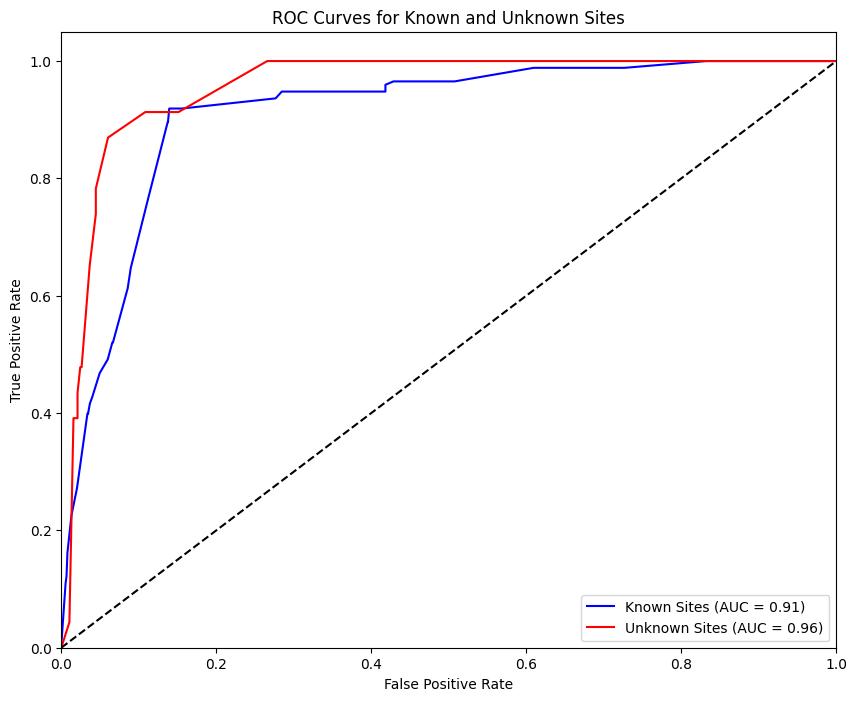

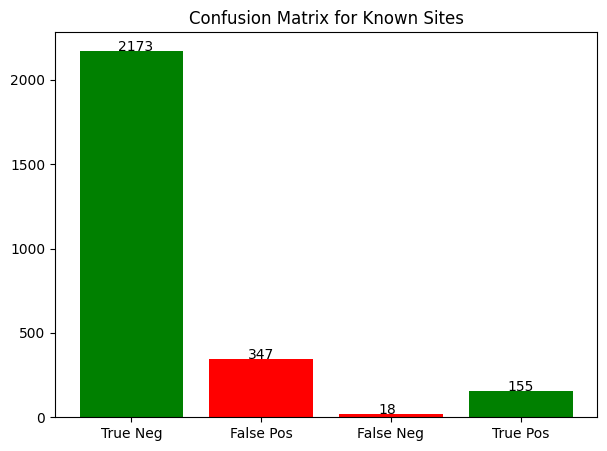

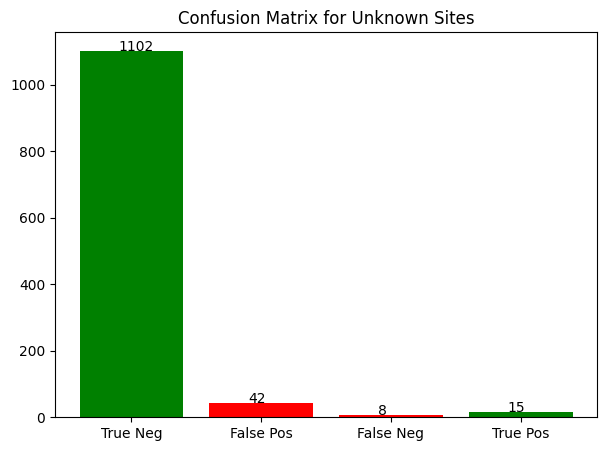

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report, accuracy_score
import numpy as np

# Step 1: Separate known and unknown sites based on 'main_working_id' in the test data
known_sites_indices = main_working_id_test[main_working_id_test.isin(main_working_id_train)].index
unknown_sites_indices = main_working_id_test[~main_working_id_test.isin(main_working_id_train)].index

# Step 2: Extract the rows for known and unknown sites
X_known = X_test_scaled_df.loc[known_sites_indices]
X_unknown = X_test_scaled_df.loc[unknown_sites_indices]

# Extract the corresponding y_test values for known and unknown sites
y_known = y_test.loc[known_sites_indices]
y_unknown = y_test.loc[unknown_sites_indices]

# Step 3: Evaluate the models for both known and unknown sites
def evaluate_model_performance(model, X, y_true, label):
    y_pred = model.predict(X)
    y_pred_prob = model.predict_proba(X)[:, 1]

    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_prob)
    conf_matrix = confusion_matrix(y_true, y_pred)
    class_report = classification_report(y_true, y_pred)

    print(f"Performance on {label} Sites:")
    print("Confusion Matrix:\n", conf_matrix)
    print(f"Accuracy: {acc}")
    print(f"AUC: {auc}")
    print("Classification Report:\n", class_report)
    print("-" * 50)

    return y_pred, y_pred_prob, conf_matrix, auc

# Plot ROC curves for both known and unknown sites
def plot_roc_curves(model, X_known, y_known, X_unknown, y_unknown):
    # ROC for known sites
    y_pred_prob_known = model.predict_proba(X_known)[:, 1]
    fpr_known, tpr_known, _ = roc_curve(y_known, y_pred_prob_known)
    auc_known = roc_auc_score(y_known, y_pred_prob_known)

    # ROC for unknown sites
    y_pred_prob_unknown = model.predict_proba(X_unknown)[:, 1]
    fpr_unknown, tpr_unknown, _ = roc_curve(y_unknown, y_pred_prob_unknown)
    auc_unknown = roc_auc_score(y_unknown, y_pred_prob_unknown)

    # Plotting the ROC curves
    plt.figure(figsize=(10, 8))
    plt.plot(fpr_known, tpr_known, label=f"Known Sites (AUC = {auc_known:.2f})", color='blue')
    plt.plot(fpr_unknown, tpr_unknown, label=f"Unknown Sites (AUC = {auc_unknown:.2f})", color='red')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Known and Unknown Sites')
    plt.legend(loc='lower right')
    plt.show()

# Plot bar chart for confusion matrix
def plot_confusion_matrix_bar(conf_matrix, title):
    labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    values = [conf_matrix[0, 0], conf_matrix[0, 1], conf_matrix[1, 0], conf_matrix[1, 1]]

    plt.figure(figsize=(7, 5))
    bars = plt.bar(labels, values, color=['green', 'red', 'red', 'green'])

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2 - 0.1, yval + 0.05, int(yval))

    plt.title(title)
    plt.show()

# Step 4: Evaluate the models and visualize the results
print("MLP Classifier")

# Performance on known sites
y_pred_known, y_pred_prob_known, conf_matrix_known, auc_known = evaluate_model_performance(MLP_MODEL, X_known, y_known, "Known")

# Performance on unknown sites
y_pred_unknown, y_pred_prob_unknown, conf_matrix_unknown, auc_unknown = evaluate_model_performance(MLP_MODEL, X_unknown, y_unknown, "Unknown")

# Plot ROC curves for known and unknown sites
plot_roc_curves(MLP_MODEL, X_known, y_known, X_unknown, y_unknown)

# Plot confusion matrix for known sites
plot_confusion_matrix_bar(conf_matrix_known, "Confusion Matrix for Known Sites")

# Plot confusion matrix for unknown sites
plot_confusion_matrix_bar(conf_matrix_unknown, "Confusion Matrix for Unknown Sites")


**•	Known Sites:**
o	Accuracy: 86%

o	AUC: 0.91

o	Precision (Seismic Events): 31%

o	Recall (Seismic Events): 90%

The model showed high recall on known sites, effectively detecting most seismic events but with lower precision, leading to some false positives.

•	Unknown Sites:

o	Accuracy: 96%

o	AUC: 0.95

o	Precision (Seismic Events): 26%

o	Recall (Seismic Events): 65%

On unknown sites, the model achieved higher accuracy and precision but exhibited a drop in recall, indicating it missed some seismic events. This pattern suggests that while the model generalizes well to new sites, it has slightly reduced sensitivity to detecting seismic events without prior historical data.


In [ ]:
!pip install shap


In [ ]:
# Choose a subset of the test data for efficiency (e.g., first 100 samples)
from sklearn.inspection import permutation_importance

# Calculate permutation feature importance
perm_importance = permutation_importance(MLP_MODEL, X_test_scaled_df, y_test, n_repeats=10, random_state=42)

# Display the feature importance
for i in perm_importance.importances_mean.argsort()[::-1]:
    print(f"{X_test_scaled_df.columns[i]:<20}: {perm_importance.importances_mean[i]:.3f}")



latest_seismic_assessment_b: 0.039
latest_seismic_assessment_c: 0.007
latest_seismic_assessment_d: -0.000
main_working_height : -0.000
latest_comprehensive_assessment_d: -0.000
latest_comprehensive_assessment_c: -0.001
mining_hazard_assessment_b: -0.001
latest_comprehensive_assessment_b: -0.001


In [ ]:
X_test_scaled_df.columns

Index(['main_working_height', 'latest_seismic_assessment_b',
       'latest_seismic_assessment_c', 'latest_seismic_assessment_d',
       'latest_comprehensive_assessment_b',
       'latest_comprehensive_assessment_c',
       'latest_comprehensive_assessment_d', 'mining_hazard_assessment_b'],
      dtype='object')

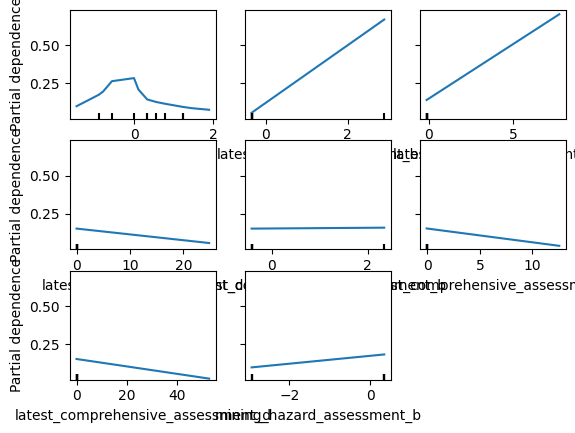

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Plot partial dependence for specific features
features = ['main_working_height', 'latest_seismic_assessment_b',
       'latest_seismic_assessment_c', 'latest_seismic_assessment_d',
       'latest_comprehensive_assessment_b',
       'latest_comprehensive_assessment_c',
       'latest_comprehensive_assessment_d', 'mining_hazard_assessment_b']  # Replace with relevant feature names in your dataset

# Generate the PDPs
display = PartialDependenceDisplay.from_estimator(MLP_MODEL, X_test_scaled_df, features)
plt.show()



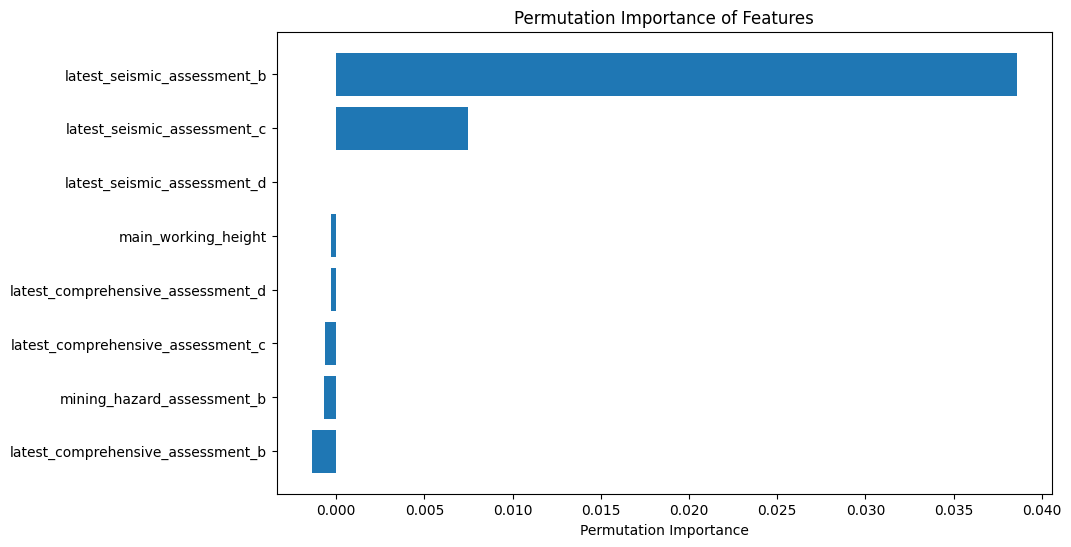

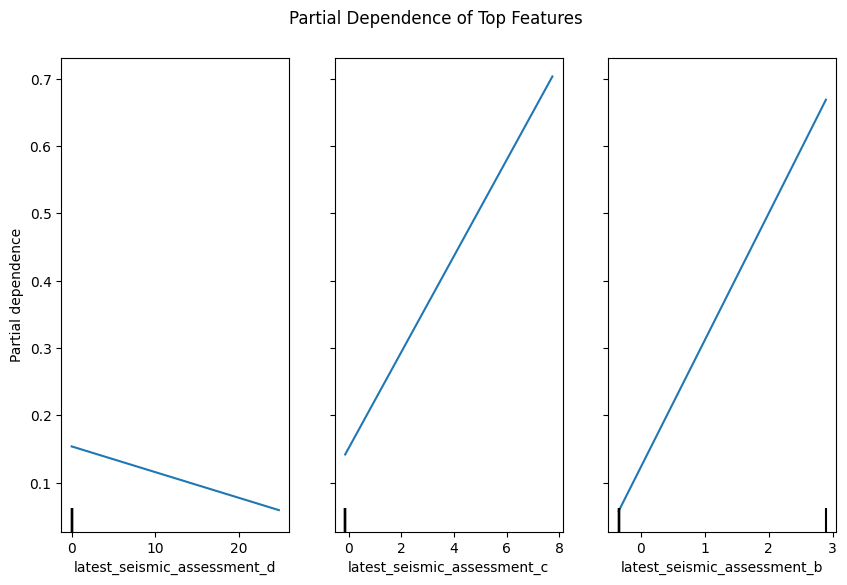

In [ ]:
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import matplotlib.pyplot as plt

# Step 1: Calculate Permutation Importance on the model
# Ensure to replace `mlp_model` with your MLP model variable
result = permutation_importance(MLP_MODEL, X_test_scaled_df, y_test, n_repeats=10, random_state=42)

# Step 2: Display Permutation Importance
# Sort features by importance for better visualization
sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(10, 6))
plt.barh(X_test_scaled_df.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Permutation Importance of Features")
plt.show()

# Step 3: Select top features from permutation importance for PDP analysis
# Choosing top 2 or 3 features based on highest importance scores for PDP
top_features = X_test_scaled_df.columns[sorted_idx][-3:]

# Step 4: Plot Partial Dependence for Top Features
# Using `PartialDependenceDisplay` to visualize the relationship of top features with predictions
fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(MLP_MODEL, X_test_scaled_df, features=top_features, ax=ax)
plt.suptitle("Partial Dependence of Top Features")
plt.subplots_adjust(top=0.9)  # Adjust title position
plt.show()


Partial Dependence of Top Features
The partial dependence plots illustrate how changes in the values of the top features affect the model's predictions, showing the model's average response as each feature varies.
1.	latest_seismic_assessment_d: The plot shows a decreasing trend, indicating that lower values of this feature are more associated with higher predictions of seismic events. This trend may suggest that lower readings of this feature contribute to the model's confidence in predicting an event.
2.	latest_seismic_assessment_c: Here, we see a positive trend; as values of latest_seismic_assessment_c increase, the likelihood of a seismic event prediction increases as well. This matches our understanding of seismic assessments, where higher risk levels should correlate with higher predicted probabilities of seismic activity.
3.	latest_seismic_assessment_b: This feature shows a strong positive relationship. As values rise, the probability of predicting a seismic event increases sharply. This feature is a key indicator that the model associates with high seismic risk, which aligns with its high permutation importance.
Together, these plots indicate that the model is highly sensitive to recent seismic assessments, especially latest_seismic_assessment_b and latest_seismic_assessment_c. The sharp increase in predictions as these values rise explains why the model might produce false positives, especially when these features show high readings even if a seismic event does not occur.


**Understanding False Positives through Feature Distributions**

The distribution plots for latest_seismic_assessment_b, latest_seismic_assessment_c, and latest_seismic_assessment_d across different prediction outcomes give us clues about why the model is generating a higher number of false positives. Let’s dive into what each plot suggests


<ipython-input-31-26d0afd2d4a9>:27: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(true_positives[feature], label='True Positives', color='green', shade=True)
<ipython-input-31-26d0afd2d4a9>:28: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(false_positives[feature], label='False Positives', color='red', shade=True)
<ipython-input-31-26d0afd2d4a9>:29: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(false_negatives[feature], label='False Negatives', color='blue', shade=True)


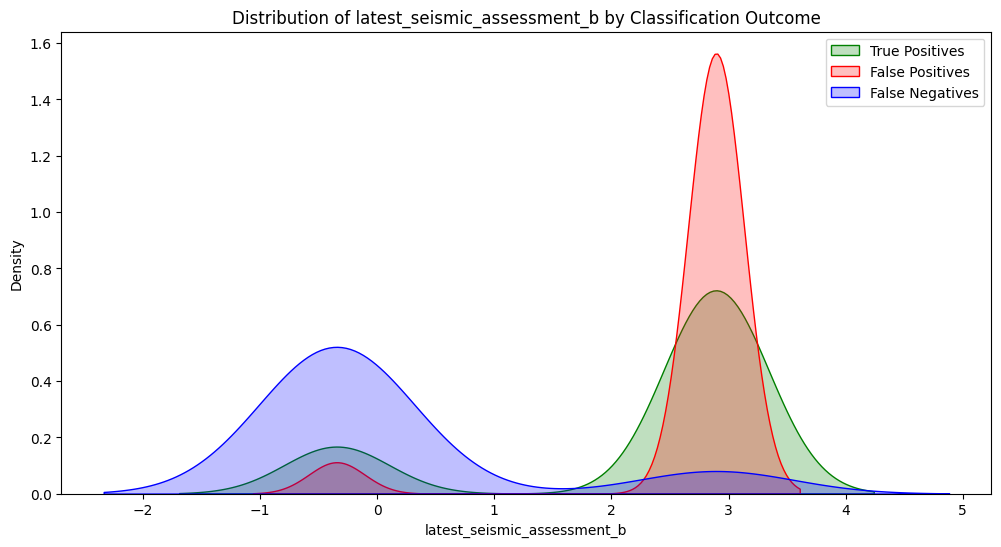

<ipython-input-31-26d0afd2d4a9>:27: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(true_positives[feature], label='True Positives', color='green', shade=True)
<ipython-input-31-26d0afd2d4a9>:28: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(false_positives[feature], label='False Positives', color='red', shade=True)
<ipython-input-31-26d0afd2d4a9>:29: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(false_negatives[feature], label='False Negatives', color='blue', shade=True)
<ipython-input-31-26d0afd2d4a9>:29: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
 

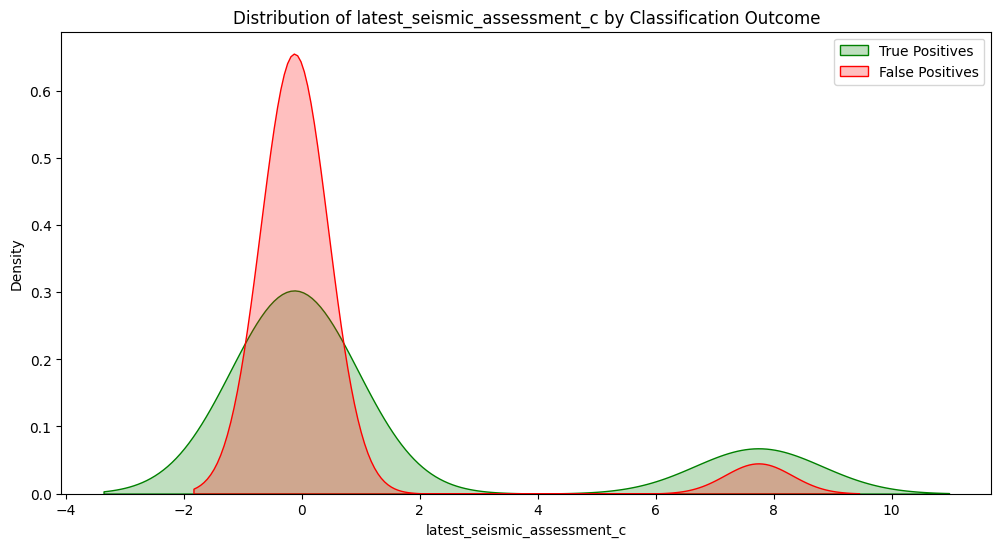

<ipython-input-31-26d0afd2d4a9>:27: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(true_positives[feature], label='True Positives', color='green', shade=True)
<ipython-input-31-26d0afd2d4a9>:28: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(false_positives[feature], label='False Positives', color='red', shade=True)
<ipython-input-31-26d0afd2d4a9>:29: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(false_negatives[feature], label='False Negatives', color='blue', shade=True)
<ipython-input-31-26d0afd2d4a9>:29: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
 

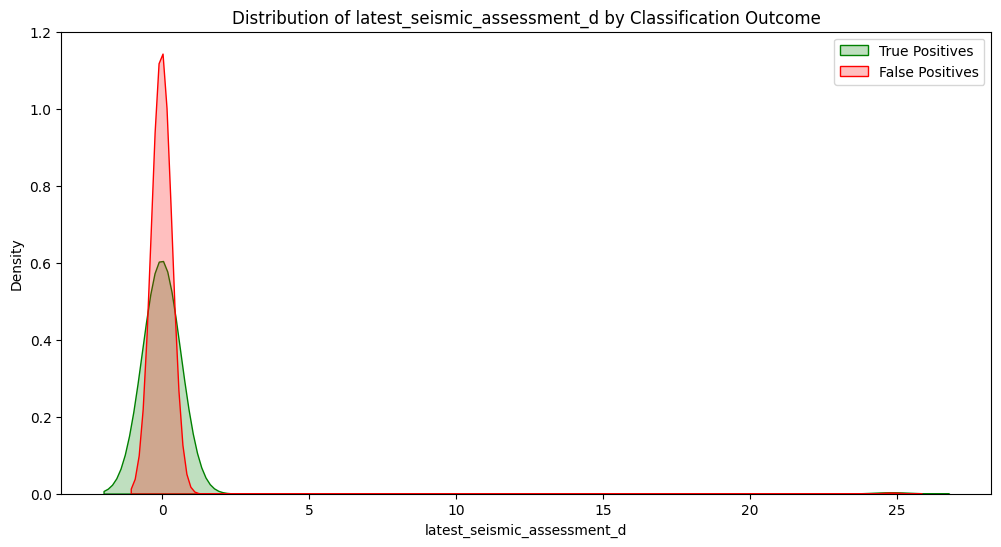

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define groups based on classification results
y_test = y_test.reset_index(drop=True)  # Reset index to match with predictions if necessary
X_test_scaled_df = X_test_scaled_df.reset_index(drop=True)

# Create a DataFrame to store test data and results
results_df = X_test_scaled_df.copy()
results_df['true_label'] = y_test
results_df['pred_label'] = y_pred

# Separate groups
true_positives = results_df[(results_df['true_label'] == 1) & (results_df['pred_label'] == 1)]
false_positives = results_df[(results_df['true_label'] == 0) & (results_df['pred_label'] == 1)]
false_negatives = results_df[(results_df['true_label'] == 1) & (results_df['pred_label'] == 0)]

# Define features to analyze
features = ['latest_seismic_assessment_b', 'latest_seismic_assessment_c', 'latest_seismic_assessment_d']

# Plot feature distributions for each group
for feature in features:
    plt.figure(figsize=(12, 6))

    # Plot distribution for each misclassification type
    sns.kdeplot(true_positives[feature], label='True Positives', color='green', shade=True)
    sns.kdeplot(false_positives[feature], label='False Positives', color='red', shade=True)
    sns.kdeplot(false_negatives[feature], label='False Negatives', color='blue', shade=True)

    plt.title(f'Distribution of {feature} by Classification Outcome')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.show()


**Distribution of latest_seismic_assessment_b by Classification Outcome**
•	True Positives (Green): This distribution shows that when the model correctly predicts a seismic event (true positive), it often corresponds with higher values of latest_seismic_assessment_b. This makes sense, as elevated values are linked with seismic risk, signaling the model to flag a potential event.
•	False Positives (Red): We see a similar density of false positives at high values of this feature. This overlap with true positives indicates that the model interprets high latest_seismic_assessment_b values as a warning, even in cases where an event does not materialize. The lack of clear separation between true and false positives suggests that while this feature is useful, it doesn’t completely distinguish between actual seismic events and non-events, causing the model to issue more alerts than necessary.
•	False Negatives (Blue): For missed events (false negatives), values of latest_seismic_assessment_b tend to be lower, reaffirming that the model heavily relies on high values of this feature to predict seismic activity.

**Distribution of latest_seismic_assessment_c by Classification Outcome**
•	True Positives and False Positives: For latest_seismic_assessment_c, both true positives and false positives cluster around moderate to high values, showing an overlap similar to that of latest_seismic_assessment_b. This tells us that the model also treats this feature as a seismic risk indicator, but it struggles to differentiate between real and false alarms when these values are in the middle-to-high range.
•	Absence of False Positives at Low Values: Unlike the other distributions, there’s a notable absence of false positives at low values, indicating that the model associates low latest_seismic_assessment_c values with low seismic risk. This suggests the model’s approach to this feature is more calibrated for lower values, but it errs on the side of caution at higher values.

**Distribution of latest_seismic_assessment_d by Classification Outcome**


•	True Positives and False Positives: The distributions for both true and false positives here are centered around lower values of latest_seismic_assessment_d. This means that the model interprets low values in this feature as a possible indicator of seismic activity. However, because not all low values signal a real event, this interpretation results in a higher number of false positives.
•	Significant Overlap: The high overlap between true and false positives for latest_seismic_assessment_d further highlights that this feature alone doesn’t reliably separate seismic events from non-events, leading to a cautious model that may overpredict events.


**Conclusion and Discussion**

This project achieved both primary objectives: accurately predicting seismic events and assessing model performance across known and unknown sites. Through a thorough evaluation using ROC curves, AUC scores, and classification metrics, we identified the MLP Classifier as the best-performing model, with an AUC close to 0.92. This model demonstrated strong predictive abilities, making it a valuable tool for detecting seismic risks in mining environments.
The analysis for known sites (sites with historical data) revealed high recall, meaning the model effectively identified most seismic events but also generated more false positives. For unknown sites (new sites without historical data), the model achieved higher accuracy and precision, though with slightly lower recall, indicating that some seismic events were missed. These findings suggest that the model can generalize to new sites, an essential factor for scaling this solution across different mining locations with minimal retraining.

**Addressing False Positives**

A key insight from this study is the high rate of false positives, particularly for features like latest_seismic_assessment_b, latest_seismic_assessment_c, and latest_seismic_assessment_d. The distribution analysis of these features showed that both true positives (correctly predicted seismic events) and false positives (predicted events that did not occur) tend to have high values, which explains why the model errs on the side of caution. In a safety-focused context, this cautious approach is often preferable, as it’s better to have some false alarms than to miss a potential seismic event. However, this also means that the model generates more alerts, some of which may not lead to actual seismic activity.

**Scalability and Limitations**
This model is designed with scalability in mind. Its ability to perform well on unknown sites, those without historical data in the training set demonstrates that it can be applied to new mining sites with minimal adjustments. The model’s adaptability to different data environments makes it a promising tool for proactive seismic risk management across various mining operations. The Grid Search Cross-Validation technique used for tuning ensures that the model is optimized and can be fine-tuned for new datasets efficiently.
Despite these strengths, there are some limitations. The model’s reliance on latest_seismic_assessment features, which show overlapping values for both seismic and non-seismic events, means that it can sometimes struggle to clearly differentiate between the two, leading to more false positives. Improving feature selection by incorporating additional metrics or engineering new features may help the model make more accurate distinctions. Additionally, while the MLP Classifier handles complex patterns well, exploring further tuning or hybrid approaches could help reduce false positives while maintaining high recall.

In summary, this project offers a solid framework for seismic prediction in mining, meeting the original goals effectively. With future enhancements in feature selection and model refinement, the solution can further improve its precision, making it even more reliable and scalable across a wide range of mining environments.


<ipython-input-32-5926f1c31271>:60: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


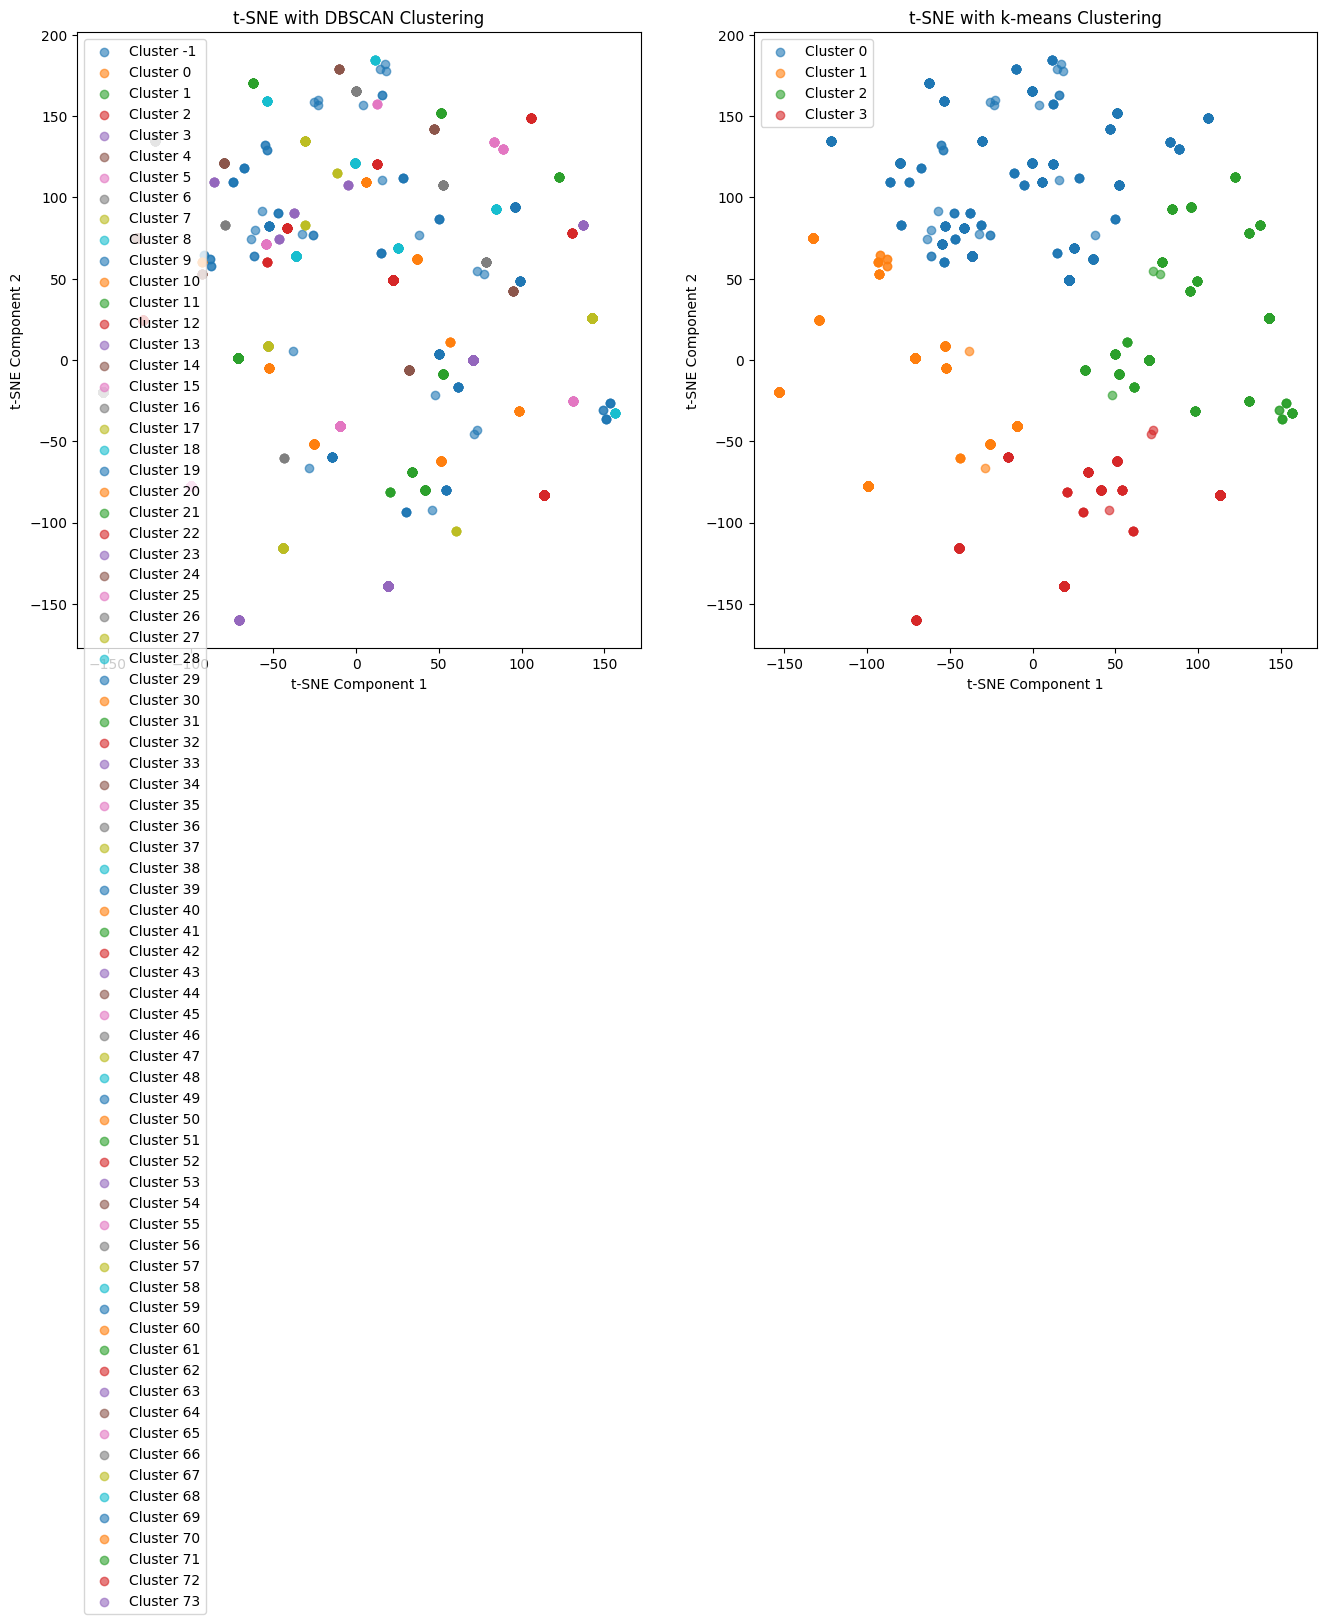

In [ ]:
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming you have a dataframe `X_test_scaled_df` and labels `y_test` and `y_pred`
# Create a new column to store the classification outcome
X_test_scaled_df['Classification Outcome'] = 'Correct'
X_test_scaled_df.loc[(y_test == 0) & (y_pred == 1), 'Classification Outcome'] = 'False Positive'
X_test_scaled_df.loc[(y_test == 1) & (y_pred == 0), 'Classification Outcome'] = 'False Negative'
X_test_scaled_df.loc[(y_test == 1) & (y_pred == 1), 'Classification Outcome'] = 'True Positive'
X_test_scaled_df.loc[(y_test == 0) & (y_pred == 0), 'Classification Outcome'] = 'True Negative'

# Extract features for t-SNE
X_features = X_test_scaled_df.drop(columns=['Classification Outcome'])

# Step 1: Apply t-SNE to reduce dimensions to 2D
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_features)

# Step 2: Apply DBSCAN or k-means clustering on the t-SNE result
# For DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_tsne)

# For k-means (e.g., assuming 4 clusters based on classification outcomes)
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(X_tsne)

# Step 3: Add t-SNE and clustering results to dataframe for visualization
X_test_scaled_df['t-SNE Component 1'] = X_tsne[:, 0]
X_test_scaled_df['t-SNE Component 2'] = X_tsne[:, 1]
X_test_scaled_df['DBSCAN Cluster'] = dbscan_labels
X_test_scaled_df['k-means Cluster'] = kmeans_labels

# Plotting
plt.figure(figsize=(16, 8))

# Plot for DBSCAN clustering
plt.subplot(1, 2, 1)
for cluster in np.unique(dbscan_labels):
    subset = X_test_scaled_df[dbscan_labels == cluster]
    plt.scatter(subset['t-SNE Component 1'], subset['t-SNE Component 2'], label=f'Cluster {cluster}', alpha=0.6)
plt.title('t-SNE with DBSCAN Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()

# Plot for k-means clustering
plt.subplot(1, 2, 2)
for cluster in range(4):  # Assuming 4 clusters
    subset = X_test_scaled_df[kmeans_labels == cluster]
    plt.scatter(subset['t-SNE Component 1'], subset['t-SNE Component 2'], label=f'Cluster {cluster}', alpha=0.6)
plt.title('t-SNE with k-means Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()

plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

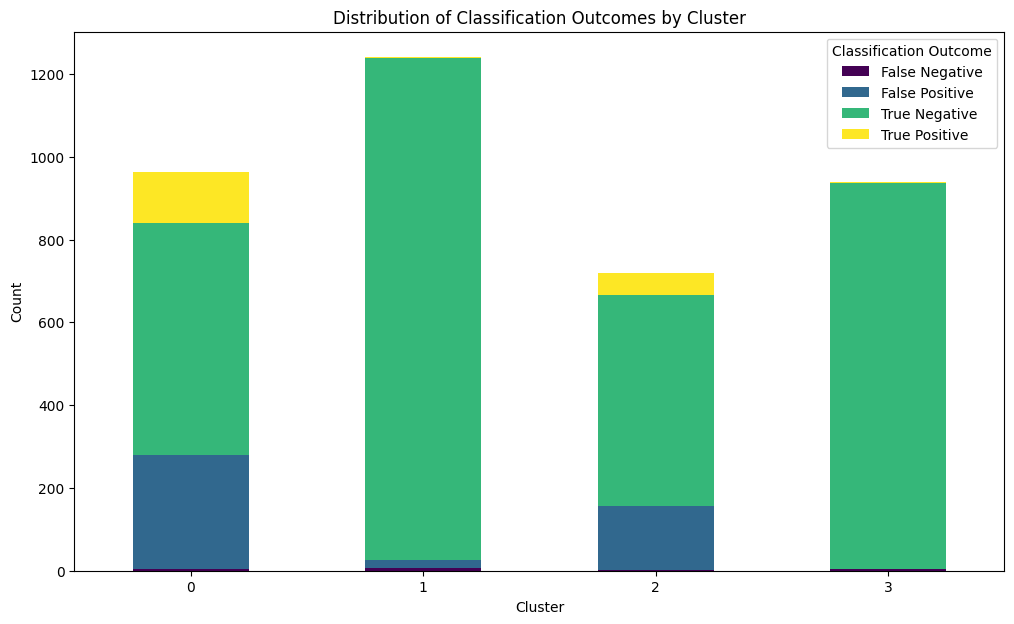

Classification Outcome Distribution per Cluster:
 Classification_Outcome  False Negative  False Positive  True Negative  \
Cluster_Label                                                           
0                                    5             275            559   
1                                    6              19           1213   
2                                    1             156            508   
3                                    3               1            933   

Classification_Outcome  True Positive  
Cluster_Label                          
0                                 125  
1                                   2  
2                                  53  
3                                   1  


In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_tsne contains the 2D t-SNE projections and y_pred contains the model's predictions
# Also assuming true labels are in y_test and k-means clustering has already been done on X_tsne
# Replace `n_clusters` with the number of clusters identified in k-means

# Perform k-means clustering on t-SNE transformed data
n_clusters = 4  # Adjust this based on your k-means output
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_tsne)

# Create a DataFrame for easier manipulation and analysis
data_df = pd.DataFrame({
    'tSNE_1': X_tsne[:, 0],
    'tSNE_2': X_tsne[:, 1],
    'True_Label': y_test,
    'Predicted_Label': y_pred,
    'Cluster_Label': cluster_labels
})

# Define the classification outcomes
data_df['Classification_Outcome'] = np.where(
    (data_df['True_Label'] == 1) & (data_df['Predicted_Label'] == 1), 'True Positive',
    np.where((data_df['True_Label'] == 0) & (data_df['Predicted_Label'] == 0), 'True Negative',
             np.where((data_df['True_Label'] == 0) & (data_df['Predicted_Label'] == 1), 'False Positive', 'False Negative'))
)

# Count the number of each classification outcome within each cluster
outcome_distribution = data_df.groupby(['Cluster_Label', 'Classification_Outcome']).size().unstack(fill_value=0)

# Plot the distribution of classification outcomes within each cluster
plt.figure(figsize=(10, 6))
outcome_distribution.plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 7))
plt.title('Distribution of Classification Outcomes by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Classification Outcome')
plt.xticks(rotation=0)
plt.show()

# Display outcome_distribution to analyze any specific clusters
print("Classification Outcome Distribution per Cluster:\n", outcome_distribution)


# Step 4: Load 4 Additional Training Datasets and Their Targets
additional_train_data_1 = pd.read_csv("/content/drive/MyDrive/AAIA'16 Data Mining Challenge/additional_data_1/additional_training_data_1.csv", header=None)
additional_train_data_2 = pd.read_csv("/content/drive/MyDrive/AAIA'16 Data Mining Challenge/additional_data_2/additional_training_data_2.csv", header=None)
additional_train_data_3 = pd.read_csv("/content/drive/MyDrive/AAIA'16 Data Mining Challenge/additional_data_3/additional_training_data_3.csv", header=None)
additional_train_data_4 = pd.read_csv("/content/drive/MyDrive/AAIA'16 Data Mining Challenge/additional_data_4/additional_training_data_4.csv", header=None)

additional_train_target_1 = pd.read_csv("/content/drive/MyDrive/AAIA'16 Data Mining Challenge/additional_data_1/additional_training_labels_1.csv", header=None)
additional_train_target_2 = pd.read_csv("/content/drive/MyDrive/AAIA'16 Data Mining Challenge/additional_data_2/additional_training_labels_2.csv", header=None)
additional_train_target_3 = pd.read_csv("/content/drive/MyDrive/AAIA'16 Data Mining Challenge/additional_data_3/additional_training_labels_3.csv", header=None)
additional_train_target_4 = pd.read_csv("/content/drive/MyDrive/AAIA'16 Data Mining Challenge/additional_data_4/additional_training_labels_4.csv", header=None)

# Assign column names to the additional training datasets
additional_train_data_1.columns = column_names
additional_train_data_2.columns = column_names
additional_train_data_3.columns = column_names
additional_train_data_4.columns = column_names

# Rename target column in additional target data
additional_train_target_1.columns = ["target"]
additional_train_target_2.columns = ["target"]
additional_train_target_3.columns = ["target"]
additional_train_target_4.columns = ["target"]

# Convert target columns to categorical
additional_train_target_1['target'] = pd.Categorical(additional_train_target_1['target'], categories=["normal", "warning"])
additional_train_target_2['target'] = pd.Categorical(additional_train_target_2['target'], categories=["normal", "warning"])
additional_train_target_3['target'] = pd.Categorical(additional_train_target_3['target'], categories=["normal", "warning"])
additional_train_target_4['target'] = pd.Categorical(additional_train_target_4['target'], categories=["normal", "warning"])

# Step 5: Combine Additional Training Data and Targets
combined_train_data_1 = pd.concat([additional_train_data_1, additional_train_target_1], axis=1)
combined_train_data_2 = pd.concat([additional_train_data_2, additional_train_target_2], axis=1)
combined_train_data_3 = pd.concat([additional_train_data_3, additional_train_target_3], axis=1)
combined_train_data_4 = pd.concat([additional_train_data_4, additional_train_target_4], axis=1)

# Step 6: Combine all Training Data
train_data_combined = pd.concat([train_data_combined, combined_train_data_1, combined_train_data_2, combined_train_data_3, combined_train_data_4])


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

def calculate_vif(X, thresh=5.0):
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["Feature"] = X.columns
    print(vif)

    # Drop features with VIF higher than threshold
    dropped = []
    while vif["VIF Factor"].max() > thresh:
        drop_feature = vif.sort_values("VIF Factor", ascending=False).iloc[0]["Feature"]
        X = X.drop(columns=[drop_feature])
        dropped.append(drop_feature)
        vif = pd.DataFrame()
        vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        vif["Feature"] = X.columns
        print(vif)

    return X, dropped


In [ ]:
from imblearn.under_sampling import ClusterCentroids

def apply_cluster_undersampling(X_train, y_train):
    cc = ClusterCentroids(random_state=0)
    X_res, y_res = cc.fit_resample(X_train, y_train)
    print(f"Resampled X shape: {X_res.shape}, Resampled y shape: {y_res.shape}")
    return X_res, y_res


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])

    # Training set confusion matrix
    ax = fig.add_subplot(1, 3, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize='true', ax=ax)
    pred = model.predict(X_train)
    conf.ax_.set_title('Training Set Performance: ' + str(sum(pred == Y_train) / len(Y_train)))

    # Test set confusion matrix
    ax = fig.add_subplot(1, 3, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize='true', ax=ax)
    pred = model.predict(X_test)
    conf.ax_.set_title('Test Set Performance: ' + str(sum(pred == Y_test) / len(Y_test)))

    # Decision boundary visualization (if 2 features)
    if X_train.shape[1] == 2:
        mins = np.min(X_train, axis=0)
        maxs = np.max(X_train, axis=0)
        xx, yy = np.meshgrid(np.arange(mins[0], maxs[0], 0.025),
                             np.arange(mins[1], maxs[1], 0.025))

        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        ax = fig.add_subplot(1, 3, 3)
        ax.contourf(xx, yy, Z, alpha=0.4)
        ax.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, s=20, edgecolor='k')


In [ ]:
 from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd

def preprocess_data(X):
    # Separate numeric and categorical columns
    numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = X.select_dtypes(include=['object']).columns

    # Create a preprocessing pipeline for numeric and categorical columns
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean'))  # Impute missing numeric values with mean
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing categorical values with the most frequent
        ('encoder', OneHotEncoder(handle_unknown='ignore'))  # OneHotEncode categorical columns
    ])

    # Combine preprocessing for both types of columns
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    # Apply the preprocessing
    X_preprocessed = preprocessor.fit_transform(X)

    # Return the preprocessed data as a DataFrame
    # Note: After OneHotEncoding, categorical columns become multiple columns
    feature_names = list(numeric_cols) + list(preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_cols))
    return pd.DataFrame(X_preprocessed, columns=feature_names)

# Apply preprocessing to the training data
X_train_preprocessed = preprocess_data(X_train)

# Step 2: Now calculate VIF on the preprocessed data
X_train_vif, dropped_features = calculate_vif(X_train_preprocessed)

# Step 3: Apply Cluster-Based Undersampling
X_train_res, y_train_res = apply_cluster_undersampling(X_train_vif, y_train)

# Continue with your pipeline...


In [ ]:


# Step 3: SVM Grid Search for Hyperparameter Tuning
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']},
  {'C': [0.1, 1, 10, 100, 1000], 'degree': [3, 4, 5, 6], 'kernel': ['poly']},
 ]

svm = SVC()
grid_search = GridSearchCV(svm, param_grid, cv=5)
grid_search.fit(X_train_res, y_train_res)

# Get the best parameters
best_system = np.argmin(grid_search.cv_results_['rank_test_score'])
params = grid_search.cv_results_['params'][best_system]
print(params)

# Apply best model and evaluate
svm_best = SVC().set_params(**params)
svm_best.fit(X_train_res, y_train_res)
eval_model(svm_best, X_train_res, y_train_res, X_test, y_test)
